# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from sklearn.model_selection import TimeSeriesSplit

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PhD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.graph_objects as go

In [3]:
def metrics(y_test, y_pred, scores):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, scores)#, max_fpr=0.1)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [5]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Interações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.iloc[:, 0]
    test_scores_std = df.iloc[:, 1]
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")

    plt.legend(loc="best")
    return plt

In [6]:
def select_low_correlation_columns(df, threshold=0.95):
    """
    Retorna uma lista de colunas com correlação de Pearson
    menor que o threshold entre si.

    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame com features numéricas.
    threshold : float
        Limite máximo de correlação permitido entre duas colunas.

    Retorna:
    --------
    selected_columns : list
        Lista de colunas selecionadas (menos correlacionadas).
    """
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Lista de colunas a remover
    removed_columns = [col for col in upper_tri.columns if any(upper_tri[col] >= threshold)]

    # Colunas selecionadas
    selected_columns = [col for col in df.columns if col not in removed_columns]
    
    return selected_columns

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    """
    Encontra o threshold ótimo com base na curva ROC,
    considerando apenas FPR <= max_fpr se especificado.
    Retorna fpr, tpr, thresholds, best_threshold e roc_auc.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr = fpr[mask]
        tpr = tpr[mask]
        thresholds = thresholds[mask]

    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]

    return fpr, tpr, thresholds, best_threshold, roc_auc


def plot_roc_multiple(models_results, max_fpr=None):
    """
    Plota múltiplas curvas ROC no mesmo gráfico.
    
    models_results: lista de dicionários, cada um contendo:
        {
            'name': str,
            'fpr': array,
            'tpr': array,
            'thresholds': array,
            'best_threshold': float,
            'roc_auc': float
        }
    """
    plt.figure(figsize=(10, 6))

    for result in models_results:
        fpr = result['fpr']
        tpr = result['tpr']
        thresholds = result['thresholds']
        best_threshold = result['best_threshold']
        roc_auc = result['roc_auc']
        name = result['name']

        # Índice do melhor threshold
        optimal_idx = np.where(thresholds == best_threshold)[0][0]

        # Curva do modelo
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")
        # Melhor threshold
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], zorder=5, s=50, label=f"{name} - Best Th = {best_threshold:.3f}")

    # Linha de referência
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Aleatório')

    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(f'Curvas ROC{" (FPR ≤ " + str(max_fpr) + ")" if max_fpr else ""}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [8]:
train = pd.read_parquet('./data/skab_train_agg_dwt.parquet.gzip') 
test = pd.read_parquet('./data/skab_test_agg_dwt.parquet.gzip') 

In [9]:
train = train.rename(columns={'anomaly': 'target', 'datetime': 'timestamp'})
test = test.rename(columns={'anomaly': 'target', 'datetime': 'timestamp'})

In [10]:
feature_model= [col for col in train.columns if col not in ['changepoint', 'timestamp', 'valve', 'target']]

In [11]:
development = train.reset_index(drop=True)

# development = development[(development['well']=='WELL-00006')].reset_index(drop=True)

development.shape

(319, 9)

In [12]:
validation = test.reset_index(drop=True)
validation.shape

(80, 9)

In [13]:
X_dev = development[feature_model].values
y_dev = development['target'].values

In [14]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [15]:
with open('./models_skab/pipeline_iForest_cmaes_dwt.pkl', 'rb') as file:
    pipe_model_iforest_cmaes = pickle.load(file)
with open('./models_skab/pipeline_LOF_cmaes_dwt.pkl', 'rb') as file:
    pipe_model_lof_cmaes = pickle.load(file)
with open('./models_skab/pipeline_LODA_cmaes_dwt.pkl', 'rb') as file:
    pipe_model_loda_cmaes = pickle.load(file)
with open('./models_skab/pipeline_PCA_cmaes_dwt.pkl', 'rb') as file:
    pipe_model_pca_cmaes = pickle.load(file)
with open('./models_skab/pipeline_OCSVM_cmaes_dwt.pkl', 'rb') as file:
    pipe_model_ocsvm_cmaes = pickle.load(file)

with open('./models_skab/pipeline_iForest_tpe_dwt.pkl', 'rb') as file:
    pipe_model_iforest_tpe = pickle.load(file)
with open('./models_skab/pipeline_LOF_tpe_dwt.pkl', 'rb') as file:
    pipe_model_lof_tpe = pickle.load(file)
with open('./models_skab/pipeline_LODA_tpe_dwt.pkl', 'rb') as file:
    pipe_model_loda_tpe = pickle.load(file)
with open('./models_skab/pipeline_PCA_tpe_dwt.pkl', 'rb') as file:
    pipe_model_pca_tpe = pickle.load(file)
with open('./models_skab/pipeline_OCSVM_tpe_dwt.pkl', 'rb') as file:
    pipe_model_ocsvm_tpe = pickle.load(file)

with open('./models_skab/pipeline_iForest_RL_dwt.pkl', 'rb') as file:
    pipe_model_iforest_hbsac = pickle.load(file)
with open('./models_skab/pipeline_LOF_RL_dwt.pkl', 'rb') as file:
    pipe_model_lof_hbsac = pickle.load(file)
with open('./models_skab/pipeline_LODA_RL_dwt.pkl', 'rb') as file:
    pipe_model_loda_hbsac = pickle.load(file)
with open('./models_skab/pipeline_PCA_RL_dwt.pkl', 'rb') as file:
    pipe_model_pca_hbsac = pickle.load(file)
with open('./models_skab/pipeline_OCSVM_RL_dwt.pkl', 'rb') as file:
    pipe_model_ocsvm_hbsac = pickle.load(file)

X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [16]:
pipe_model_iforest_hbsac

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 IsolationForest(contamination=0.00014, max_features=0.31,
                                 max_samples=0.61, n_estimators=13,
                                 random_state=42))])

In [17]:
pipe_model_iforest_cmaes

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 IsolationForest(contamination=0.00268, max_features=0.61,
                                 max_samples=0.72, n_estimators=132,
                                 random_state=42))])

In [18]:
pipe_model_iforest_tpe

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 IsolationForest(contamination=0.0021, max_features=0.96,
                                 max_samples=0.94, n_estimators=53,
                                 random_state=42))])

In [19]:
pipe_model_lof_hbsac

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LocalOutlierFactor(contamination=0.0002, n_jobs=-1,
                                    n_neighbors=24, novelty=True))])

In [20]:
pipe_model_lof_cmaes

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LocalOutlierFactor(contamination=0.0041, n_jobs=-1,
                                    n_neighbors=13, novelty=True))])

In [21]:
pipe_model_lof_tpe

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LocalOutlierFactor(contamination=0.00488, n_jobs=-1,
                                    n_neighbors=25, novelty=True))])

In [22]:
pipe_model_loda_hbsac

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LODA(contamination=0.005, n_bins=52, n_random_cuts=10))])

In [23]:
pipe_model_loda_cmaes

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LODA(contamination=0.00272, n_bins=51, n_random_cuts=317))])

In [24]:
pipe_model_loda_tpe

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 LODA(contamination=0.00288, n_bins=51, n_random_cuts=425))])

In [25]:
pipe_model_pca_hbsac

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 PCA(contamination=0.00069, copy=True, iterated_power='auto',
  n_components=0.91, n_selected_components=None, random_state=42,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False))])

In [26]:
pipe_model_pca_cmaes

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 PCA(contamination=0.00426, copy=True, iterated_power='auto',
  n_components=0.88, n_selected_components=None, random_state=42,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False))])

In [27]:
pipe_model_pca_tpe

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 PCA(contamination=0.00043, copy=True, iterated_power='auto',
  n_components=None, n_selected_components=None, random_state=42,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False))])

In [28]:
pipe_model_ocsvm_hbsac

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma=0.01,
   kernel='poly', max_iter=-1, nu=0.00089, shrinking=True, tol=0.001,
   verbose=False))])

In [29]:
pipe_model_ocsvm_cmaes

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma=0.071,
   kernel='rbf', max_iter=-1, nu=0.00181, shrinking=True, tol=0.001,
   verbose=False))])

In [30]:
pipe_model_ocsvm_tpe

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['Volume Flow RateRMS_mean',
                                                 'Volume Flow RateRMS_std',
                                                 'Volume Flow RateRMS_min',
                                                 'Volume Flow RateRMS_max',
                                                 'Volume Flow '
                                                 'RateRMS_energy_L0',
                                                 'Volume Flow '
                                                 'RateRMS_std_L0'])),
                ('estimator',
                 OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma=0.012,
   kernel='poly', max_iter=-1, nu=0.00065, shrinking=True, tol=0.001,
   verbose=False))])

In [31]:
# ------------------------------
# Função para encontrar threshold ótimo
# ------------------------------
def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr = fpr[mask]
        tpr = tpr[mask]
        thresholds = thresholds[mask]
    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]
    return fpr, tpr, thresholds, best_threshold, roc_auc


# ------------------------------
# Função para calcular métricas
# ------------------------------
def compute_metrics(y_true, y_pred, y_score):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    auc = roc_auc_score(y_true, y_score)
    return acc, prec, rec, spec, f1, auc


# ------------------------------
# Dicionário de modelos
# ------------------------------
models = {
    "iForest": {
        "HBSAC-ADT": pipe_model_iforest_hbsac,
        "CMA-ES": pipe_model_iforest_cmaes,
        "TPE": pipe_model_iforest_tpe
    },
    "LOF": {
        "HBSAC-ADT": pipe_model_lof_hbsac,
        "CMA-ES": pipe_model_lof_cmaes,
        "TPE": pipe_model_lof_tpe
    },
    "PCA": {
        "HBSAC-ADT": pipe_model_pca_hbsac,
        "CMA-ES": pipe_model_pca_cmaes,
        "TPE": pipe_model_pca_tpe
    },
    "LODA": {
        "HBSAC-ADT": pipe_model_loda_hbsac,
        "CMA-ES": pipe_model_loda_cmaes,
        "TPE": pipe_model_loda_tpe
    },
    "OCSVM": {
        "HBSAC-ADT": pipe_model_ocsvm_hbsac,
        "CMA-ES": pipe_model_ocsvm_cmaes,
        "TPE": pipe_model_ocsvm_tpe
    }
}




In [32]:
# ------------------------------
# Avaliação usando threshold ótimo
# ------------------------------
rows = []

for model_name, variants in models.items():
    for method, pipe in variants.items():
        # scores dos conjuntos de desenvolvimento e validação
        if hasattr(pipe, "predict_proba"):
            scores_dev = pipe.predict_proba(X_dev)[:, 1]
            scores_valid = pipe.predict_proba(X_valid)[:, 1]
        elif hasattr(pipe, "decision_function"):
            if model_name in ["iForest", "LOF"]:
                scores_dev = -pipe.decision_function(X_dev)
                scores_valid = -pipe.decision_function(X_valid)
            else:
                scores_dev = pipe.decision_function(X_dev)
                scores_valid = pipe.decision_function(X_valid)
        elif hasattr(pipe, "score_samples"):
            if model_name in ["iForest", "LOF"]:
                scores_dev = -pipe.score_samples(X_dev)
                scores_valid = -pipe.score_samples(X_valid)
            else:
                scores_dev = pipe.score_samples(X_dev)
                scores_valid = pipe.score_samples(X_valid)
        else:
            scores_dev = pipe.predict(X_dev)
            scores_valid = pipe.predict(X_valid)

        # encontra threshold ótimo usando desenvolvimento
        _, _, _, best_threshold, auc_dev = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)

        # ------------------------------
        # Avaliação no conjunto de desenvolvimento
        # ------------------------------
        y_pred_dev = (scores_dev >= best_threshold).astype(int)
        # y_pred_dev = pipe.predict(X_dev)
        # if model_name in ["iForest", "LOF"]:
        #     y_pred_dev = np.where(y_pred_dev == -1, 1, 0)
        acc_dev, prec_dev, rec_dev, spec_dev, f1_dev, auc_dev = compute_metrics(y_dev, y_pred_dev, scores_dev)
        rows.append([
            model_name, method, "dev",
            acc_dev, prec_dev, rec_dev, spec_dev, f1_dev, auc_dev
        ])

        # ------------------------------
        # Avaliação no conjunto de validação
        # ------------------------------
        y_pred_valid = (scores_valid >= best_threshold).astype(int)
        # y_pred_valid = pipe.predict(X_valid)
        # if model_name in ["iForest", "LOF"]:
        #     y_pred_valid = np.where(y_pred_valid == -1, 1, 0)
        acc_valid, prec_valid, rec_valid, spec_valid, f1_valid, auc_valid = compute_metrics(y_valid, y_pred_valid, scores_valid)
        rows.append([
            model_name, method, "valid",
            acc_valid, prec_valid, rec_valid, spec_valid, f1_valid, auc_valid
        ])

# ------------------------------
# Monta DataFrame e arredonda
# ------------------------------
df_results = pd.DataFrame(rows, columns=[
    "Model", "Method", "Set", "Accuracy", "Precision", "Recall", "Specificity", "F1-score", "AUC-ROC"
])

df_results = df_results.round(3)


In [33]:
df_results[df_results['Set'] == 'valid']

,Model,Method,Set,Accuracy,Precision,Recall,Specificity,F1-score,AUC-ROC
1,iForest,HBSAC-ADT,valid,0.875,0.926,0.758,0.957,0.833,0.887
3,iForest,CMA-ES,valid,0.900,0.903,0.848,0.936,0.875,0.914
5,iForest,TPE,valid,0.888,0.875,0.848,0.915,0.862,0.909
7,LOF,HBSAC-ADT,valid,0.850,0.800,0.848,0.851,0.824,0.887
9,LOF,CMA-ES,valid,0.800,0.718,0.848,0.766,0.778,0.903
11,LOF,TPE,valid,0.862,0.824,0.848,0.872,0.836,0.885
13,PCA,HBSAC-ADT,valid,0.875,0.848,0.848,0.894,0.848,0.896
15,PCA,CMA-ES,valid,0.875,0.848,0.848,0.894,0.848,0.896
17,PCA,TPE,valid,0.875,0.848,0.848,0.894,0.848,0.899
19,LODA,HBSAC-ADT,valid,0.850,0.784,0.879,0.830,0.829,0.809


In [34]:
df_results[df_results['Set'] == 'dev']

,Model,Method,Set,Accuracy,Precision,Recall,Specificity,F1-score,AUC-ROC
0,iForest,HBSAC-ADT,dev,0.887,0.925,0.778,0.959,0.845,0.925
2,iForest,CMA-ES,dev,0.903,0.899,0.849,0.938,0.873,0.928
4,iForest,TPE,dev,0.906,0.907,0.849,0.943,0.877,0.924
6,LOF,HBSAC-ADT,dev,0.909,0.929,0.833,0.959,0.879,0.917
8,LOF,CMA-ES,dev,0.903,0.913,0.833,0.948,0.871,0.930
10,LOF,TPE,dev,0.909,0.929,0.833,0.959,0.879,0.916
12,PCA,HBSAC-ADT,dev,0.906,0.914,0.841,0.948,0.876,0.915
14,PCA,CMA-ES,dev,0.906,0.914,0.841,0.948,0.876,0.915
16,PCA,TPE,dev,0.906,0.929,0.825,0.959,0.874,0.918
18,LODA,HBSAC-ADT,dev,0.803,0.698,0.881,0.751,0.779,0.820


In [35]:
# === Funções auxiliares ===
def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr, tpr, thresholds = fpr[mask], tpr[mask], thresholds[mask]
    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)
    optimal_idx = np.argmax(tpr - fpr)
    return fpr, tpr, thresholds, thresholds[optimal_idx], roc_auc




import matplotlib.colors as mcolors

def plot_roc_multiples(models_results, title, max_fpr=None):
    """
    Plota múltiplas curvas ROC, usando cores fixas para cada método de otimização
    (TPE, CMA-ES, HBSAC-ADT), mostrando o threshold ótimo na legenda e linhas tracejadas.
    """
    plt.figure(figsize=(10, 6))

    # Cores para cada método de otimização
    opt_colors = {
        'HBSAC-DT': "#1f77b4",  # Azul tradicional
        'CMA-ES': "#9467bd",    # Roxo
        'TPE': "#2ca02c"        # Verde
    }

    for result in models_results:
        fpr, tpr = result['fpr'], result['tpr']
        thr, best_th, auc = result['thresholds'], result['best_threshold'], result['roc_auc']
        name = result['name']

        # Detecta o método de otimização no nome do modelo
        if 'cmaes' in name.lower():
            opt_name = 'CMA-ES'
        elif 'tpe' in name.lower():
            opt_name = 'TPE'
        elif 'hbsac' in name.lower() or 'rl' in name.lower():
            opt_name = 'HBSAC-DT'
        else:
            opt_name = 'Unknown'

        color = opt_colors.get(opt_name, '#333333')
        optimal_idx = np.where(thr == best_th)[0][0]

        # Curva ROC
        plt.plot(fpr, tpr, lw=2, color=color,
                 label=f"{name} (AUC-ROC = {auc:.3f}, Threshold = {best_th:.2e})")

        # Ponto ótimo
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx],
                    color=color, edgecolor='black', s=100, zorder=5, marker='o')
        
        # Linhas tracejadas
        plt.axhline(y=tpr[optimal_idx], color=color, linestyle='--', alpha=0.6)
        plt.axvline(x=fpr[optimal_idx], color=color, linestyle='--', alpha=0.6)

    # Linha aleatória
    plt.plot([0, 1], [0, 1], linestyle=':', color='gray', lw=1.5)

    plt.xlabel('False Positive Rate (FPR)', fontsize=14.5)
    plt.ylabel('True Positive Rate (TPR)', fontsize=14.5)
    
    # Aumenta o tamanho dos valores nos eixos
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.legend(loc='lower right', fontsize=14.5, frameon=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


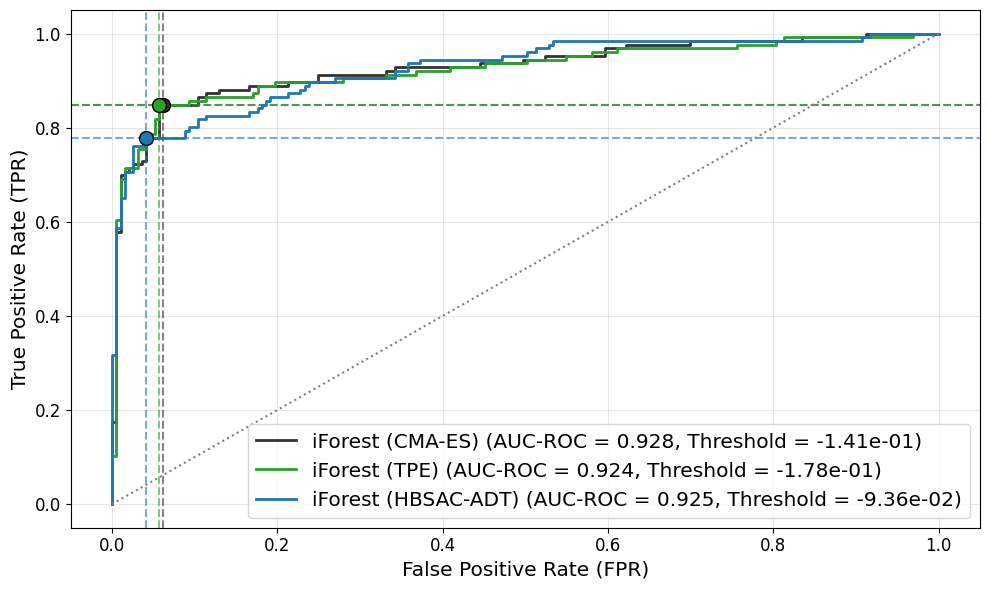

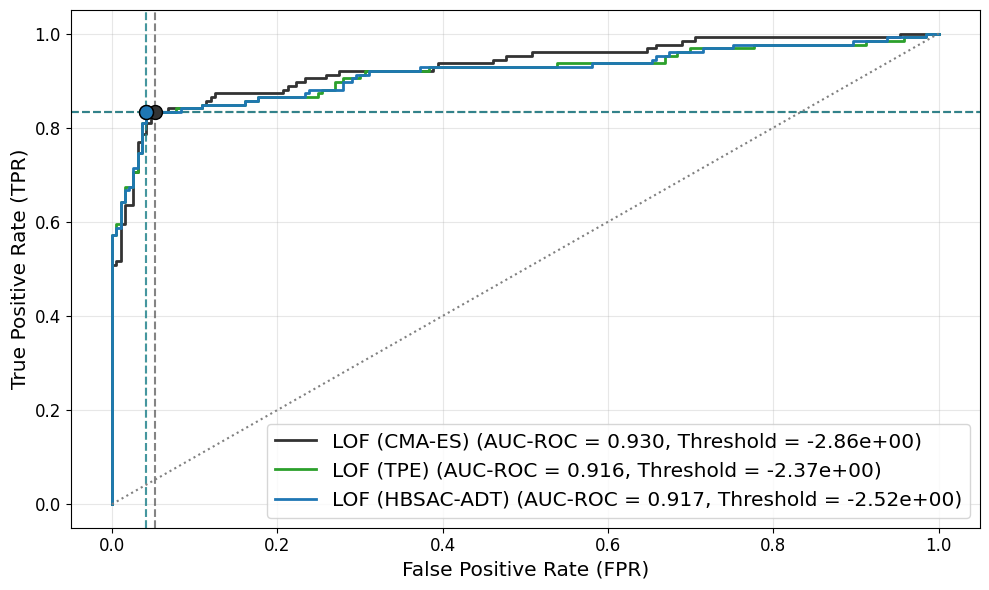

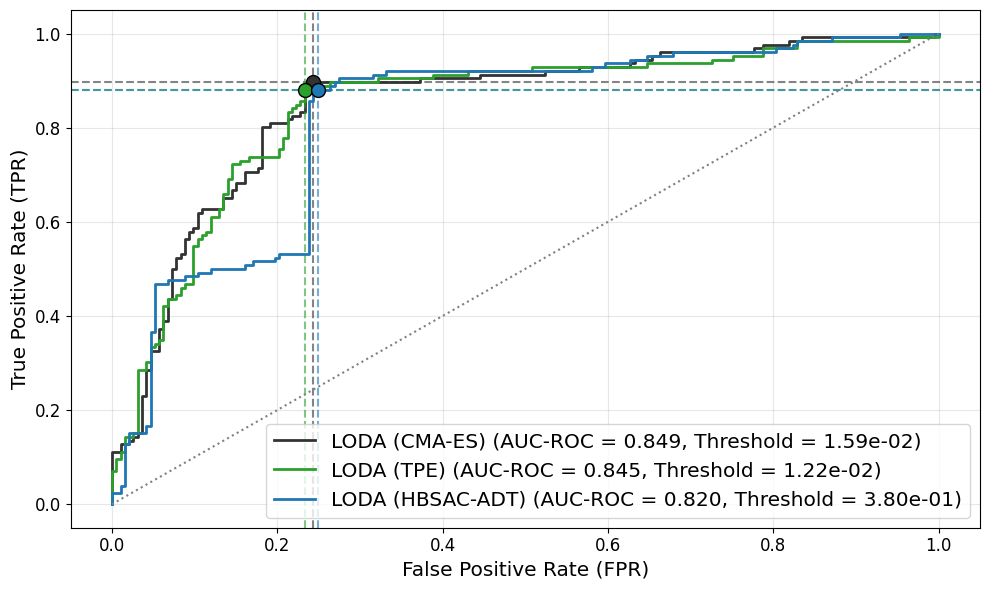

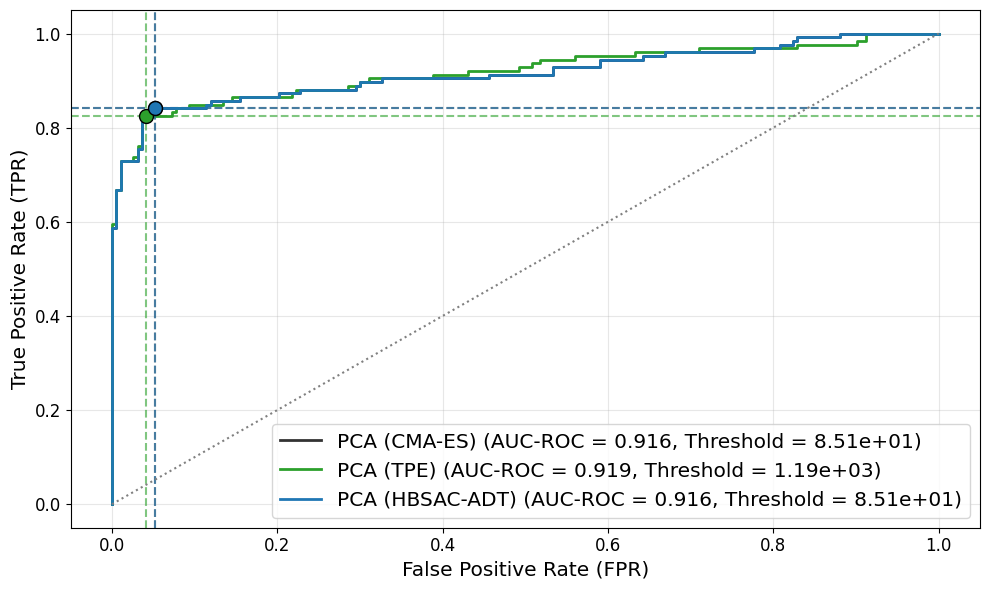

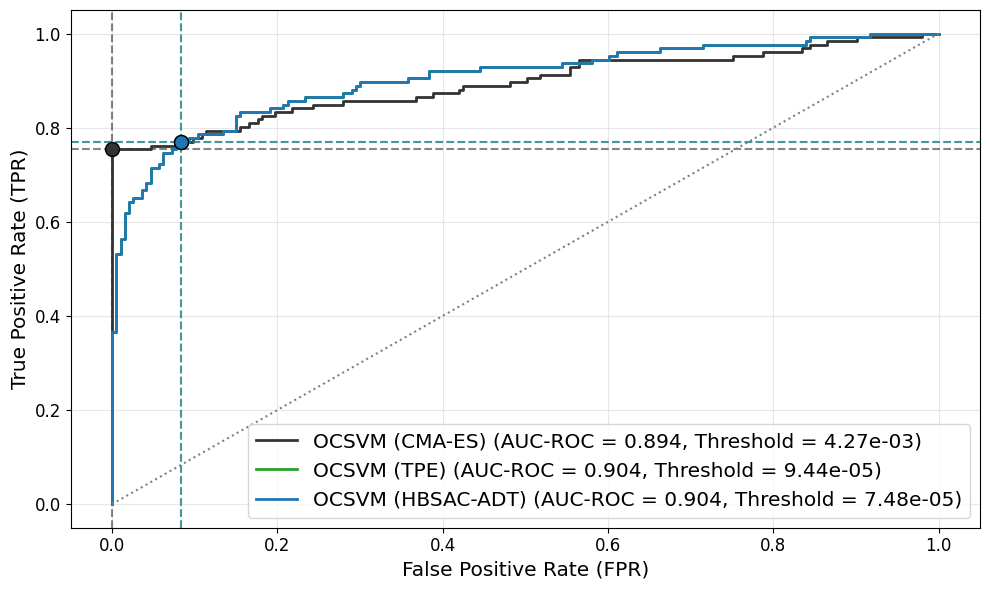

In [36]:
# Agrupamento por família de modelos
families = {
    "iForest": {
        "CMA-ES": pipe_model_iforest_cmaes,
        "TPE": pipe_model_iforest_tpe,
        "HBSAC-ADT": pipe_model_iforest_hbsac,
    },
    "LOF": {
        "CMA-ES": pipe_model_lof_cmaes,
        "TPE": pipe_model_lof_tpe,
        "HBSAC-ADT": pipe_model_lof_hbsac,
    },
    "LODA": {
        "CMA-ES": pipe_model_loda_cmaes,
        "TPE": pipe_model_loda_tpe,
        "HBSAC-ADT": pipe_model_loda_hbsac,
    },
    "PCA": {
        "CMA-ES": pipe_model_pca_cmaes,
        "TPE": pipe_model_pca_tpe,
        "HBSAC-ADT": pipe_model_pca_hbsac,
    },
    "OCSVM": {
        "CMA-ES": pipe_model_ocsvm_cmaes,
        "TPE": pipe_model_ocsvm_tpe,
        "HBSAC-ADT": pipe_model_ocsvm_hbsac,
    }
}
list_models_pyod = ['LODA', 'PCA', 'OCSVM']

for family_name, models in families.items():
    results = []
    for opt_name, model in models.items():
        # Ajuste de sinal para os modelos PyOD
        if family_name in list_models_pyod:
            y_scores = model.decision_function(X_dev)
        else:
            y_scores = -model.decision_function(X_dev)

        fpr, tpr, thr, best_th, auc = find_optimal_threshold(y_dev, y_scores)
        results.append({
            'name': f"{family_name} ({opt_name})",
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thr,
            'best_threshold': best_th,
            'roc_auc': auc
        })
    
    plot_roc_multiples(results, title=f"ROC Curves - {family_name}")

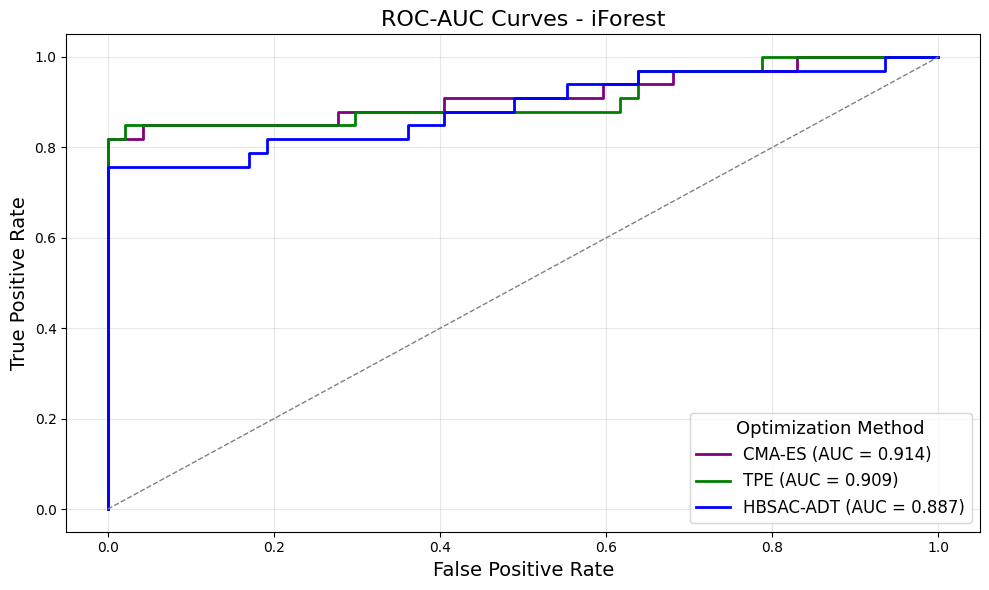

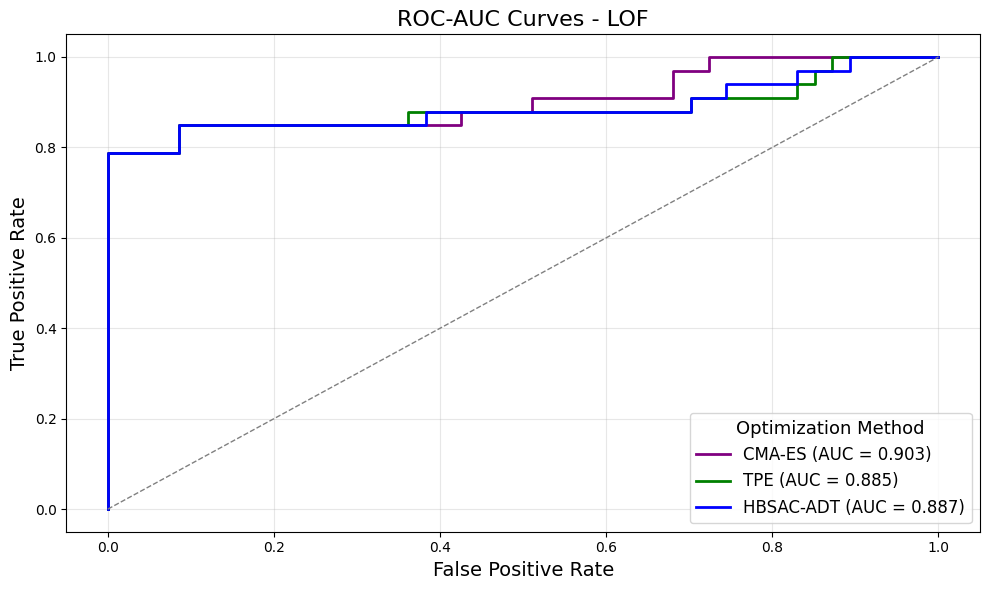

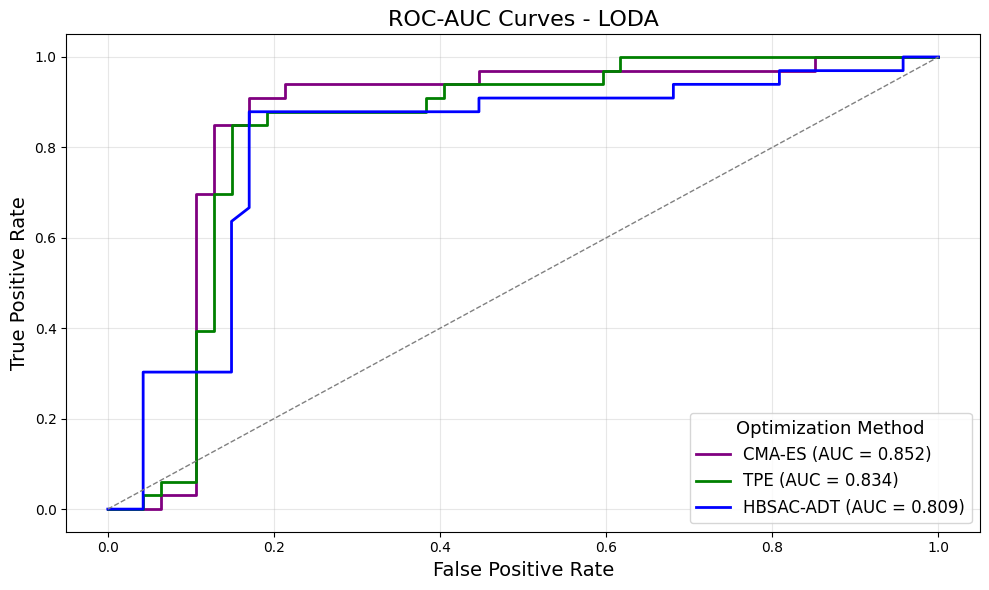

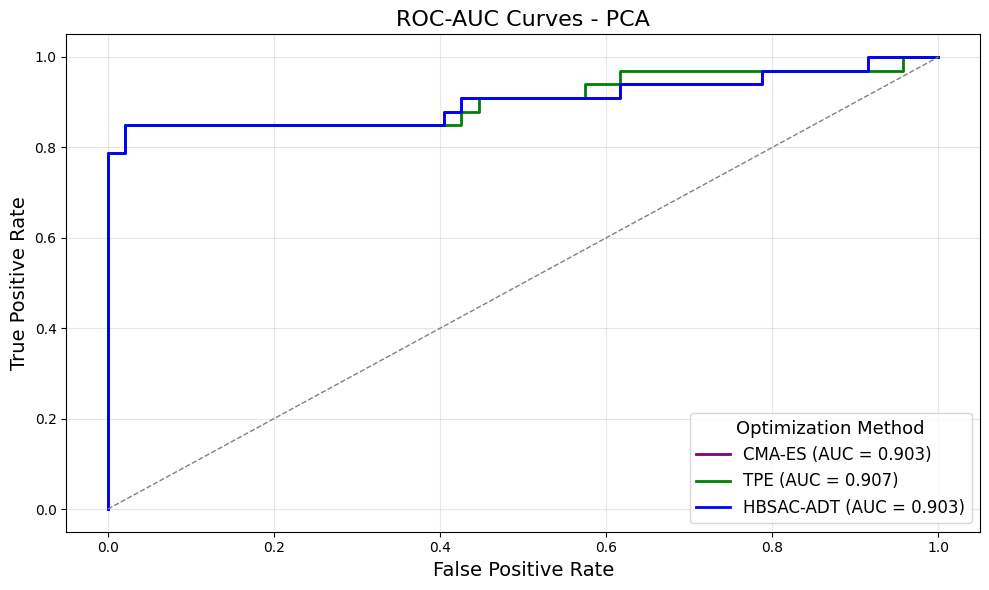

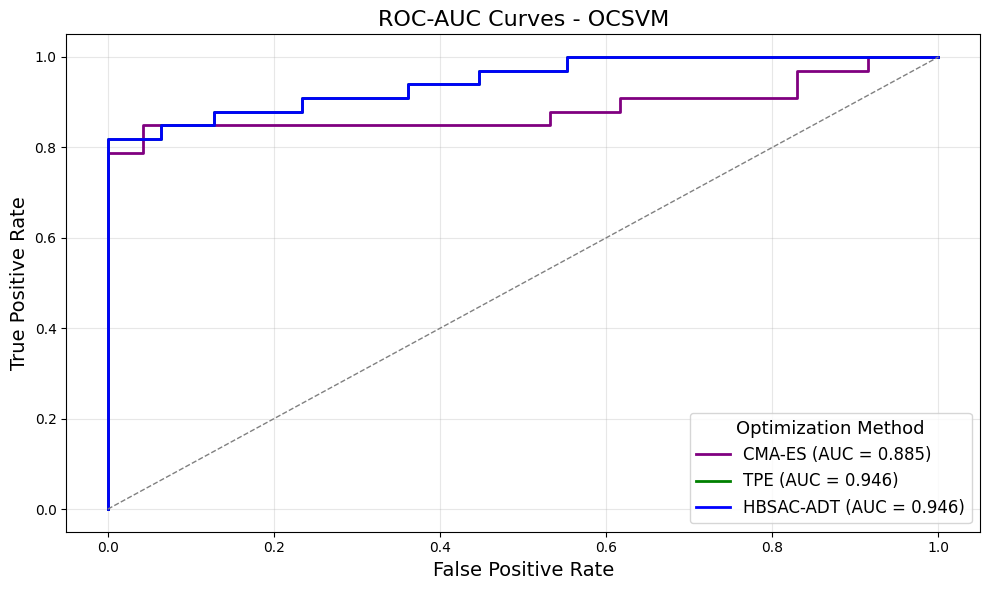

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Organizando pipelines por modelo e método
pipelines_by_model = {
    "iForest": {
        "CMA-ES": pipe_model_iforest_cmaes,
        "TPE": pipe_model_iforest_tpe,
        "HBSAC-ADT": pipe_model_iforest_hbsac
    },
    "LOF": {
        "CMA-ES": pipe_model_lof_cmaes,
        "TPE": pipe_model_lof_tpe,
        "HBSAC-ADT": pipe_model_lof_hbsac
    },
    "LODA": {
        "CMA-ES": pipe_model_loda_cmaes,
        "TPE": pipe_model_loda_tpe,
        "HBSAC-ADT": pipe_model_loda_hbsac
    },
    "PCA": {
        "CMA-ES": pipe_model_pca_cmaes,
        "TPE": pipe_model_pca_tpe,
        "HBSAC-ADT": pipe_model_pca_hbsac
    },
    "OCSVM": {
        "CMA-ES": pipe_model_ocsvm_cmaes,
        "TPE": pipe_model_ocsvm_tpe,
        "HBSAC-ADT": pipe_model_ocsvm_hbsac
    }
}

# Cores para os métodos
method_colors = {
    "CMA-ES": "purple",
    "TPE": "green",
    "HBSAC-ADT": "blue"
}

# Modelos que precisam inverter os scores
invert_scores = ["iForest", "LOF"]

# Loop para criar gráfico para cada modelo
for model_name, pipelines in pipelines_by_model.items():
    plt.figure(figsize=(10,6))
    
    for method_name, pipeline in pipelines.items():
        # Obtém scores
        if hasattr(pipeline, "decision_function"):
            y_scores = pipeline.decision_function(X_valid)
        else:
            y_scores = pipeline.predict_proba(X_valid)[:,1]
        
        # Inverte scores se necessário
        if model_name in invert_scores:
            y_scores = -y_scores
        
        fpr, tpr, _ = roc_curve(y_valid, y_scores)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, color=method_colors[method_name], lw=2,
                 label=f"{method_name} (AUC = {roc_auc:.3f})")
    
    plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
    plt.title(f"ROC-AUC Curves - {model_name}", fontsize=16)
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.legend(loc="lower right", fontsize=12, title="Optimization Method", title_fontsize=13)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [38]:
# Supondo que você já tenha os pipelines carregados e X_valid, y_valid
pipelines = {
    "iForest": {"HBSAC-ADT": pipe_model_iforest_hbsac,
                "CMA-ES": pipe_model_iforest_cmaes,
                "TPE": pipe_model_iforest_tpe},
    "LOF": {"HBSAC-ADT": pipe_model_lof_hbsac,
            "CMA-ES": pipe_model_lof_cmaes,
            "TPE": pipe_model_lof_tpe},
    "LODA": {"HBSAC-ADT": pipe_model_loda_hbsac,
             "CMA-ES": pipe_model_loda_cmaes,
             "TPE": pipe_model_loda_tpe},
    "PCA": {"HBSAC-ADT": pipe_model_pca_hbsac,
            "CMA-ES": pipe_model_pca_cmaes,
            "TPE": pipe_model_pca_tpe},
    "OCSVM": {"HBSAC-ADT": pipe_model_ocsvm_hbsac,
              "CMA-ES": pipe_model_ocsvm_cmaes,
              "TPE": pipe_model_ocsvm_tpe}
}

# binary_predictions = {}

# for model_name, method_pipes in pipelines.items():
#     binary_predictions[model_name] = {}
#     for method_name, pipe in method_pipes.items():
#         # Gera predições binárias diretas
#         y_pred = pipe.predict(X_valid)

#         # Converte convenção (-1 = anômalo → 1, 1 = normal → 0) para LOF e iForest
#         if model_name in ["iForest", "LOF"]:
#             y_pred = np.where(y_pred == -1, 1, 0)

#         binary_predictions[model_name][method_name] = y_pred


binary_predictions = {}

for model_name, method_pipes in pipelines.items():
    binary_predictions[model_name] = {}
    for method_name, pipe in method_pipes.items():
        # Para LOF e iForest, multiplicar a pontuação por -1
        if model_name in ["iForest", "LOF"]:
            scores = -pipe.decision_function(X_valid)
        else:
            scores = pipe.decision_function(X_valid)
        
        # Encontrar threshold ótimo baseado na curva ROC
        _, _, _, best_threshold, _ = find_optimal_threshold(y_valid, scores)
        
        # Gerar predição binária
        y_pred_bin = (scores >= best_threshold).astype(int)
        binary_predictions[model_name][method_name] = y_pred_bin


McNemar p-values for iForest


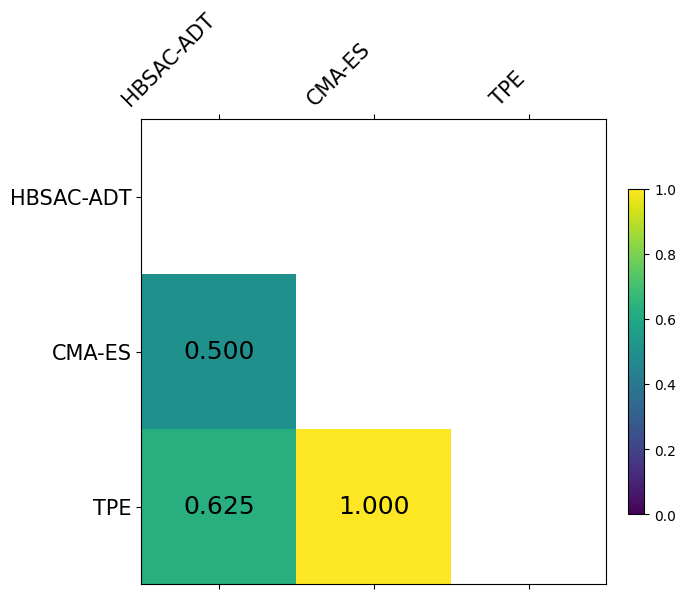

McNemar p-values for LOF


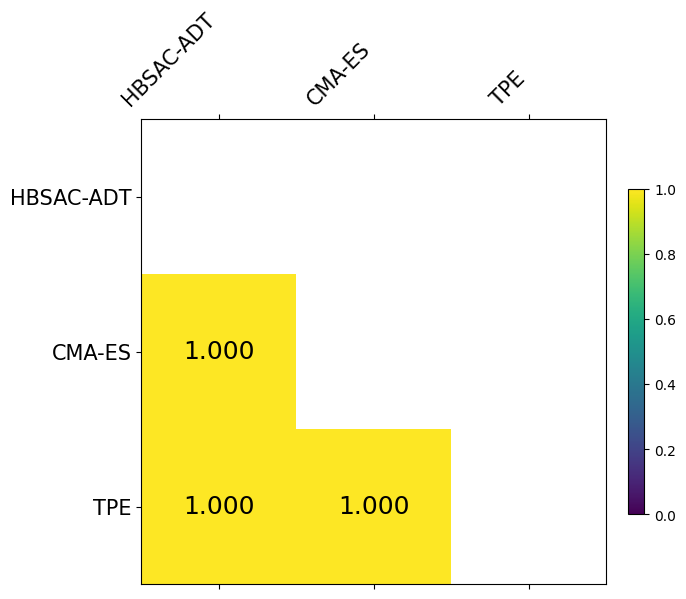

McNemar p-values for LODA


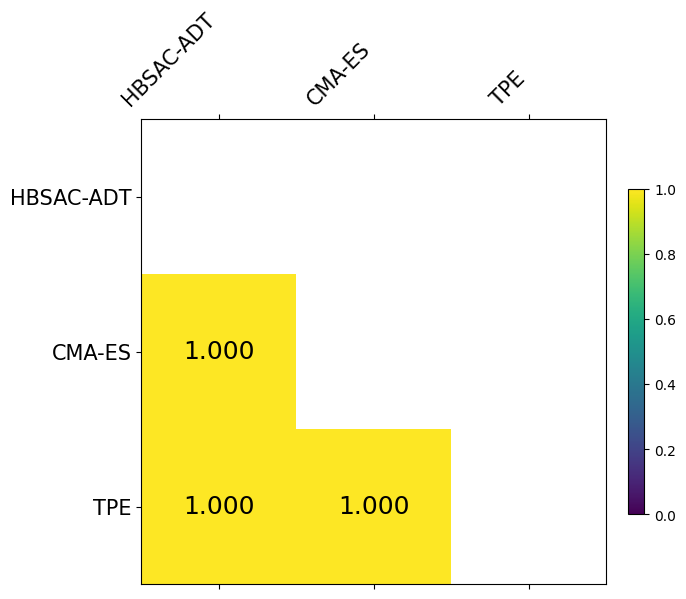

McNemar p-values for PCA


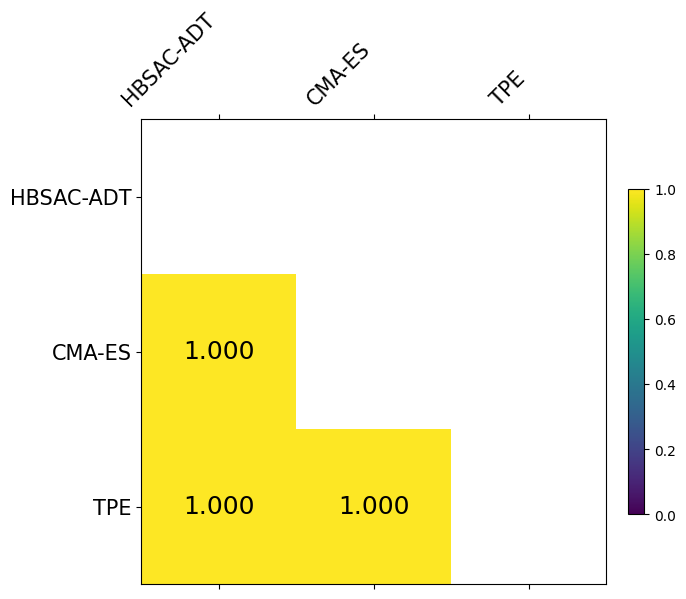

McNemar p-values for OCSVM


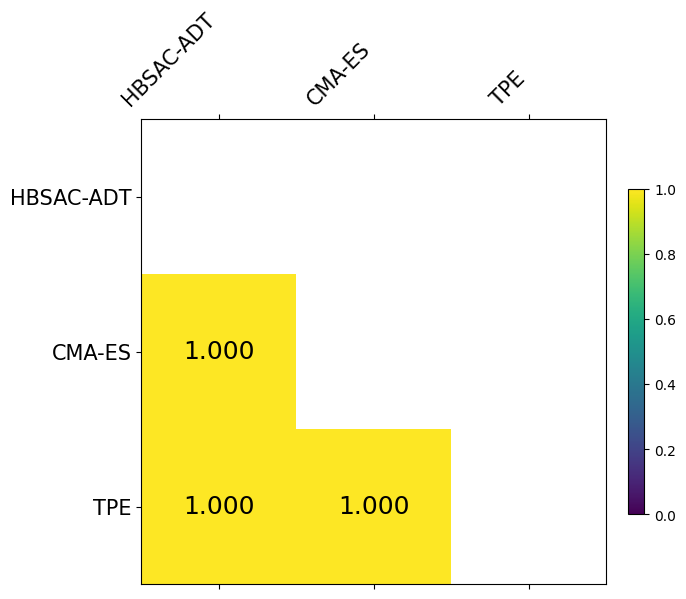

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.evaluate import mcnemar_table
from statsmodels.stats.contingency_tables import mcnemar

models = ["iForest", "LOF", "LODA", "PCA", "OCSVM"]
methods = ["HBSAC-ADT", "CMA-ES", "TPE"]

for model in models:
    n_methods = len(methods)
    mat = np.full((n_methods, n_methods), np.nan)
    
    # Comparação entre métodos
    for i in range(n_methods):
        for j in range(i):
            y_pred1 = binary_predictions[model][methods[i]]
            y_pred2 = binary_predictions[model][methods[j]]
            
            # Gera tabela de contingência
            table = mcnemar_table(y_target=y_valid, y_model1=y_pred1, y_model2=y_pred2)
            result = mcnemar(table, exact=True)
            mat[i, j] = result.pvalue
    
    # Plot da matriz triangular
    plt.figure(figsize=(7,6))
    cax = plt.matshow(mat, cmap="viridis", vmin=0, vmax=1, fignum=1)
    print(f"McNemar p-values for {model}")
    
    # Labels
    plt.xticks(range(n_methods), methods, rotation=45, ha="right", fontsize=15)
    plt.yticks(range(n_methods), methods, fontsize=15)
    
    # Inserir p-valores nas células
    for r in range(n_methods):
        for c in range(n_methods):
            if r > c:
                val = mat[r,c]
                plt.text(c, r, f"{val:.3f}", va='center', ha='center', 
                         color="white" if val < 0.5 else "black", fontsize=18)
    
    plt.colorbar(cax, fraction=0.03, pad=0.04)
    plt.tight_layout()
    plt.show()


In [40]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Interações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.iloc[:, 0]
    test_scores_std = df.iloc[:, 1]
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")

    plt.legend(loc="best")
    return plt

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



def plot_learning_curves_from_df(df, title, ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000), model_colors=None):
    """
    Plota múltiplas curvas de aprendizado (AUC-ROC) a partir de um DataFrame com várias execuções/metodos.
    Permite especificar cores associadas a cada metodo.

    Requer colunas:
    - 'roc_auc_mean': valores médios da AUC
    - 'roc_auc_std' : desvios padrão da AUC
    - 'metodo'      : nome do metodo (str), para agrupar as curvas

    Parâmetros:
    - model_colors: dicionário {nome_metodo: cor}, opcional. Se None, usa cores padrão.
    """
    plt.figure(figsize=(8, 5))  
    plt.title(title, fontsize=16)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Episodes", fontsize=14)
    plt.ylabel("AUC-ROC", fontsize=14)
    plt.grid(alpha=0.3)

    metodos = df['metodo'].unique()

    # Cores padrão caso model_colors não seja fornecido
    cores_padrao = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta', 'brown', 'olive', 'pink']

    for idx, metodo in enumerate(metodos):
        if model_colors and metodo in model_colors:
            cor = model_colors[metodo]
        else:
            cor = cores_padrao[idx % len(cores_padrao)]
        
        df_metodo = df[df['metodo'] == metodo]
        plt.fill_between(train_sizes,
                         df_metodo['roc_auc_mean'] - df_metodo['roc_auc_std'],
                         df_metodo['roc_auc_mean'] + df_metodo['roc_auc_std'],
                         alpha=0.2, color=cor)
        plt.plot(train_sizes, df_metodo['roc_auc_mean'], label=metodo, color=cor, linewidth=3)

    # Aumenta tamanho da legenda
    plt.legend(loc="best", fontsize=12)
    
    # Ajusta ticks do eixo X e Y
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    return plt



In [42]:
results_df_iforest_tpe = pd.read_csv(f'./metrics_skab/results_iforest_tpe_dwt.csv')
results_df_iforest_cmaes = pd.read_csv(f'./metrics_skab/results_iforest_cmaes_dwt.csv')
results_df_iforest_sac = pd.read_csv(f'./metrics_skab/results_df_iforest_dwt.csv') 
results_df_iforest_sac  = results_df_iforest_sac[['mean_test_roc_auc', 'std_test_roc_auc']]
results_df_iforest_sac.columns = ['roc_auc_mean', 'roc_auc_std']
results_df_iforest_tpe['metodo'] = 'TPE'
results_df_iforest_cmaes['metodo'] = 'CMA-ES'
results_df_iforest_sac['metodo'] = 'HBSAC-ADT'

results_df_iforest = pd.concat([results_df_iforest_sac, results_df_iforest_tpe, results_df_iforest_cmaes], axis=0)

results_df_lof_tpe = pd.read_csv(f'./metrics_skab/results_lof_tpe_dwt.csv')
results_df_lof_cmaes = pd.read_csv(f'./metrics_skab/results_lof_cmaes_dwt.csv')
results_df_lof_sac = pd.read_csv(f'./metrics_skab/results_df_lof_dwt.csv')
results_df_lof_sac  = results_df_lof_sac[['mean_test_roc_auc', 'std_test_roc_auc']]
results_df_lof_sac.columns = ['roc_auc_mean', 'roc_auc_std']
results_df_lof_tpe['metodo'] = 'TPE'
results_df_lof_cmaes['metodo'] = 'CMA-ES'
results_df_lof_sac['metodo'] = 'HBSAC-ADT'
results_df_lof = pd.concat([results_df_lof_sac, results_df_lof_tpe, results_df_lof_cmaes], axis=0)

results_df_pca_tpe = pd.read_csv(f'./metrics_skab/results_pca_tpe_dwt.csv')
results_df_pca_cmaes = pd.read_csv(f'./metrics_skab/results_pca_cmaes_dwt.csv')
results_df_pca_sac = pd.read_csv(f'./metrics_skab/results_df_pca_dwt.csv')
results_df_pca_sac  = results_df_pca_sac[['mean_test_roc_auc', 'std_test_roc_auc']]
results_df_pca_sac.columns = ['roc_auc_mean', 'roc_auc_std']
results_df_pca_tpe['metodo'] = 'TPE'
results_df_pca_cmaes['metodo'] = 'CMA-ES'
results_df_pca_sac['metodo'] = 'HBSAC-ADT'
results_df_pca = pd.concat([results_df_pca_sac, results_df_pca_tpe, results_df_pca_cmaes], axis=0)

results_df_loda_tpe = pd.read_csv(f'./metrics_skab/results_loda_tpe_dwt.csv')
results_df_loda_cmaes = pd.read_csv(f'./metrics_skab/results_loda_cmaes_dwt.csv')
results_df_loda_sac = pd.read_csv(f'./metrics_skab/results_df_loda_dwt.csv')
results_df_loda_sac  = results_df_loda_sac[['mean_test_roc_auc', 'std_test_roc_auc']]
results_df_loda_sac.columns = ['roc_auc_mean', 'roc_auc_std']
results_df_loda_tpe['metodo'] = 'TPE'
results_df_loda_cmaes['metodo'] = 'CMA-ES'
results_df_loda_sac['metodo'] = 'HBSAC-ADT'
results_df_loda = pd.concat([results_df_loda_sac, results_df_loda_tpe, results_df_loda_cmaes], axis=0)

results_df_ocsvm_tpe = pd.read_csv(f'./metrics_skab/results_ocsvm_tpe_dwt.csv')
results_df_ocsvm_cmaes = pd.read_csv(f'./metrics_skab/results_ocsvm_cmaes_dwt.csv')
results_df_ocsvm_sac = pd.read_csv(f'./metrics_skab/results_df_ocsvm_dwt.csv')
results_df_ocsvm_sac  = results_df_ocsvm_sac[['mean_test_roc_auc', 'std_test_roc_auc']]
results_df_ocsvm_sac.columns = ['roc_auc_mean', 'roc_auc_std']
results_df_ocsvm_tpe['metodo'] = 'TPE'
results_df_ocsvm_cmaes['metodo'] = 'CMA-ES'
results_df_ocsvm_sac['metodo'] = 'HBSAC-ADT'
results_df_ocsvm = pd.concat([results_df_ocsvm_sac, results_df_ocsvm_tpe, results_df_ocsvm_cmaes], axis=0)

In [43]:
results_df_iforest['reward']  =100 * (results_df_iforest['roc_auc_mean'] - results_df_iforest['roc_auc_std'])
results_df_lof['reward']      =100 * (results_df_lof['roc_auc_mean'] - results_df_lof['roc_auc_std'])
results_df_pca['reward']      =100 * (results_df_pca['roc_auc_mean'] - results_df_pca['roc_auc_std'])
results_df_loda['reward']     =100 * (results_df_loda['roc_auc_mean'] - results_df_loda['roc_auc_std'])
results_df_ocsvm['reward']    =100 * (results_df_ocsvm['roc_auc_mean'] - results_df_ocsvm['roc_auc_std'])

In [44]:
from scipy.stats import kruskal
import pandas as pd

# Dicionário com DataFrames de cada modelo
model_dfs = {
    "iForest": results_df_iforest,
    "LOF": results_df_lof,
    "PCA": results_df_pca,
    "LODA": results_df_loda,
    "OCSVM": results_df_ocsvm
}

# Comparações de interesse
comparisons = [("HBSAC-ADT", "CMA-ES"),
               ("HBSAC-ADT", "TPE"),
               ("TPE", "CMA-ES")]

# Inicializa dicionário para armazenar resultados
kruskal_results = {}

for model_name, df in model_dfs.items():
    kruskal_results[model_name] = {}
    for m1, m2 in comparisons:
        data1 = df[df['metodo'] == m1]['roc_auc_mean'].values
        data2 = df[df['metodo'] == m2]['roc_auc_mean'].values
        stat, pvalue = kruskal(data1, data2)
        kruskal_results[model_name][f"{m1} vs {m2}"] = pvalue

# Converte em DataFrame para melhor visualização
kruskal_results_df = pd.DataFrame(kruskal_results).T
kruskal_results_df



,HBSAC-ADT vs CMA-ES,HBSAC-ADT vs TPE,TPE vs CMA-ES
iForest,0.000000e+00,2.022235e-275,2.238348e-02
LOF,1.884872e-169,1.139801e-214,2.253974e-171
PCA,3.657440e-269,1.912246e-148,4.638060e-34
LODA,7.394781e-79,1.020281e-26,6.460583e-97
OCSVM,1.724916e-44,1.150184e-184,7.682914e-229


In [45]:
from scipy.stats import mannwhitneyu
import pandas as pd

# Dicionário com DataFrames de cada modelo
model_dfs = {
    "iForest": results_df_iforest,
    "LOF": results_df_lof,
    "PCA": results_df_pca,
    "LODA": results_df_loda,
    "OCSVM": results_df_ocsvm
}

# Inicializa dicionário para armazenar resultados
pairwise_results = {}

# Comparações de interesse
comparisons = [("HBSAC-ADT", "CMA-ES"),
               ("HBSAC-ADT", "TPE"),
               ("TPE", "CMA-ES")]

for model_name, df in model_dfs.items():
    pairwise_results[model_name] = {}
    for m1, m2 in comparisons:
        data1 = df[df['metodo'] == m1]['roc_auc_mean'].values
        data2 = df[df['metodo'] == m2]['roc_auc_mean'].values
        stat, pvalue = mannwhitneyu(data1, data2, alternative='two-sided')
        pairwise_results[model_name][f"{m1} vs {m2}"] = pvalue

# Converte em DataFrame para melhor visualização
pairwise_results_df = pd.DataFrame(pairwise_results).T
pairwise_results_df


,HBSAC-ADT vs CMA-ES,HBSAC-ADT vs TPE,TPE vs CMA-ES
iForest,0.000000e+00,2.025015e-275,2.238580e-02
LOF,1.887036e-169,1.141204e-214,2.256590e-171
PCA,3.662903e-269,1.914281e-148,4.641827e-34
LODA,7.400181e-79,1.020708e-26,6.465824e-97
OCSVM,1.725856e-44,1.151511e-184,7.692777e-229


In [46]:
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import pandas as pd
import numpy as np

# Dicionário com DataFrames de cada modelo
# Cada DataFrame deve conter as colunas: ['metodo', 'roc_auc_mean']
# com valores de ROC-AUC por fold (ou execução repetida)
model_dfs = {
    "iForest": results_df_iforest,
    "LOF": results_df_lof,
    "PCA": results_df_pca,
    "LODA": results_df_loda,
    "OCSVM": results_df_ocsvm
}

# Inicializa dicionário para armazenar resultados
friedman_results = {}
nemenyi_results = {}

for model_name, df in model_dfs.items():
    # Garante a ordem consistente dos métodos
    methods = ["HBSAC-ADT", "CMA-ES", "TPE"]

    # Cria matriz de dados: linhas = folds, colunas = métodos
    pivot_df = df.pivot(columns="metodo", values="roc_auc_mean")[methods]

    # Aplica teste de Friedman (requere >= 2 observações por método)
    stat, pvalue = friedmanchisquare(*[pivot_df[m] for m in methods])
    friedman_results[model_name] = {"statistic": stat, "pvalue": pvalue}

    # Se Friedman for significativo, aplica teste post-hoc de Nemenyi
    nemenyi = sp.posthoc_nemenyi_friedman(pivot_df.values)
    nemenyi.index = nemenyi.columns = methods
    nemenyi_results[model_name] = nemenyi

# Converte os resultados do Friedman em DataFrame
friedman_df = pd.DataFrame(friedman_results).T

print("==== Teste de Friedman ====")
print(friedman_df)
print("\n==== Teste post-hoc de Nemenyi (p-valores por par) ====")
for model, nem in nemenyi_results.items():
    print(f"\nModelo: {model}")
    display(nem)


==== Teste de Friedman ====
           statistic         pvalue
iForest  1333.878000  2.249430e-290
LOF      1142.378656  8.622373e-249
PCA      1145.859145  1.513032e-249
LODA      443.616000   4.677454e-97
OCSVM     966.972417  1.058297e-210

==== Teste post-hoc de Nemenyi (p-valores por par) ====

Modelo: iForest


,HBSAC-ADT,CMA-ES,TPE
HBSAC-ADT,1.0,0.000000,0.000000
CMA-ES,0.0,1.000000,0.997522
TPE,0.0,0.997522,1.000000



Modelo: LOF


,HBSAC-ADT,CMA-ES,TPE
HBSAC-ADT,1.0,0.0,0.0
CMA-ES,0.0,1.0,0.0
TPE,0.0,0.0,1.0



Modelo: PCA


,HBSAC-ADT,CMA-ES,TPE
HBSAC-ADT,1.0,0.000000e+00,0.000000e+00
CMA-ES,0.0,1.000000e+00,7.101479e-09
TPE,0.0,7.101479e-09,1.000000e+00



Modelo: LODA


,HBSAC-ADT,CMA-ES,TPE
HBSAC-ADT,1.000000e+00,0.0,5.250622e-08
CMA-ES,0.000000e+00,1.0,0.000000e+00
TPE,5.250622e-08,0.0,1.000000e+00



Modelo: OCSVM


,HBSAC-ADT,CMA-ES,TPE
HBSAC-ADT,1.000000e+00,3.330669e-16,0.0
CMA-ES,3.330669e-16,1.000000e+00,0.0
TPE,0.000000e+00,0.000000e+00,1.0


In [47]:
cores = ['blue', 'green', 'purple']

# Cria um dicionário associando cada método a uma cor
metodos = results_df_iforest['metodo'].unique()
model_colors = {metodo: cores[idx % len(cores)] for idx, metodo in enumerate(metodos)}

In [48]:
import matplotlib.pyplot as plt

def plot_learning_curves_from_df_reward(df, title="", model_colors=None):
    """
    Plota a soma acumulada da coluna 'reward' para cada método presente no DataFrame.

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame contendo as colunas:
        - 'metodo' : nome do método
        - 'reward' : valores de recompensa
    title : str, opcional
        Título do gráfico.
    model_colors : dict, opcional
        Dicionário {metodo: cor} para personalizar cores.
    """
    plt.figure(figsize=(8, 5))

    # Garante que o DataFrame contenha as colunas necessárias
    if not {'metodo', 'reward'}.issubset(df.columns):
        raise ValueError("O DataFrame deve conter as colunas 'metodo' e 'reward'.")

    # Itera sobre cada método e plota a soma acumulada de reward
    for metodo in df['metodo'].unique():
        df_metodo = df[df['metodo'] == metodo].copy()
        df_metodo['reward_cumsum'] = df_metodo['reward'].cumsum()

        color = model_colors.get(metodo) if model_colors else None

        plt.plot(
            range(len(df_metodo)),
            df_metodo['reward_cumsum'],
            label=metodo,
            linewidth=2,
            color=color
        )

    plt.title(title, fontsize=12)
    plt.xlabel("Observações", fontsize=11)
    plt.ylabel("Soma acumulada de reward", fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title="Método", fontsize=9)
    plt.tight_layout()
    plt.show()


In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_learning_curves_from_df_reward_variation(df, title="", model_colors=None):
    """
    Plota a taxa de variação acumulada (diferença absoluta acumulada)
    da coluna 'reward' para cada método presente no DataFrame.

    Parâmetros
    ----------
    df : pd.DataFrame
        DataFrame contendo as colunas:
        - 'metodo' : nome do método
        - 'reward' : valores de recompensa
    title : str, opcional
        Título do gráfico.
    model_colors : dict, opcional
        Dicionário {metodo: cor} para personalizar cores.
    """
    plt.figure(figsize=(8, 5))

    # Verificação de colunas necessárias
    if not {'metodo', 'reward'}.issubset(df.columns):
        raise ValueError("O DataFrame deve conter as colunas 'metodo' e 'reward'.")

    for metodo in df['metodo'].unique():
        df_metodo = df[df['metodo'] == metodo].copy()
        df_metodo = df_metodo.reset_index(drop=True)

        # Calcula a diferença absoluta entre observações consecutivas
        df_metodo['reward_diff'] = df_metodo['reward'].diff().fillna(0)

        # Soma acumulada das diferenças (variação acumulada)
        df_metodo['reward_diff_cumsum'] = df_metodo['reward_diff'].cumsum()

        color = model_colors.get(metodo) if model_colors else None

        plt.plot(
            range(len(df_metodo)),
            df_metodo['reward_diff_cumsum'],
            label=metodo,
            linewidth=2,
            color=color
        )

    plt.title(title, fontsize=12)
    plt.xlabel("Observações", fontsize=11)
    plt.ylabel("Taxa de variação acumulada do reward", fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title="Método", fontsize=9)
    plt.tight_layout()
    plt.show()


In [50]:
def plot_learning_curves_from_df_mean_moving(df, title="", model_colors=None, window_size=20):
    """
    Plots the accumulated variation rate (absolute difference accumulated)
    of the 'reward' column with a moving average for smoothing.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the columns:
        - 'metodo' : name of the method
        - 'reward' : reward values
    title : str, optional
        Title of the plot.
    model_colors : dict, optional
        Dictionary {method: color} to customize colors.
    window_size : int, optional
        Window size for moving average (default = 20).
    """
    plt.figure(figsize=(12, 6))  # Aumentado

    # Check required columns
    if not {'metodo', 'reward'}.issubset(df.columns):
        raise ValueError("The DataFrame must contain the columns 'metodo' and 'reward'.")

    for metodo in df['metodo'].unique():
        df_metodo = df[df['metodo'] == metodo].copy()
        df_metodo = df_metodo.reset_index(drop=True)

        # # Calculate absolute difference between consecutive observations
        # df_metodo['reward_diff'] = df_metodo['reward'].diff().fillna(0)

        # # Cumulative sum of differences (accumulated variation)
        # df_metodo['reward_diff_cumsum'] = df_metodo['reward_diff'].cumsum()

        # Apply moving average for smoothing
        df_metodo['reward_smooth'] = (
            df_metodo['reward']
            .rolling(window=window_size, min_periods=1)
            .mean()
        )

        color = model_colors.get(metodo) if model_colors else None

        # Plot smoothed curve
        plt.plot(
            range(len(df_metodo)),
            df_metodo['reward_smooth'],
            label=f"{metodo} (moving average)",
            linewidth=2.5,  # mais espessa
            color=color
        )

    # Estilo dos eixos e legendas
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel("Episodes", fontsize=15, labelpad=14)
    plt.ylabel("Reward", fontsize=15, labelpad=14)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title="Method", title_fontsize=15, fontsize=15, loc='best')
    plt.tight_layout()
    plt.show()

In [51]:
def plot_learning_curves_from_df_mean_std_moving(df, title="", model_colors=None, window_size=20):
    """
    Plots the accumulated variation rate (absolute difference accumulated)
    of the 'reward' column with a moving average for smoothing, including
    moving standard deviation as shaded area.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the columns:
        - 'metodo' : name of the method
        - 'reward' : reward values
    title : str, optional
        Title of the plot.
    model_colors : dict, optional
        Dictionary {method: color} to customize colors.
    window_size : int, optional
        Window size for moving average (default = 20).
    """
    plt.figure(figsize=(12, 6))  # Aumentado

    # Check required columns
    if not {'metodo', 'reward'}.issubset(df.columns):
        raise ValueError("The DataFrame must contain the columns 'metodo' and 'reward'.")

    for metodo in df['metodo'].unique():
        df_metodo = df[df['metodo'] == metodo].copy()
        df_metodo = df_metodo.reset_index(drop=True)

        # Moving average
        df_metodo['reward_smooth'] = (
            df_metodo['reward']
            .rolling(window=window_size, min_periods=1)
            .mean()
        )

        # Moving standard deviation
        df_metodo['reward_std'] = (
            df_metodo['reward']
            .rolling(window=window_size, min_periods=1)
            .std()
            .fillna(0)
        )

        color = model_colors.get(metodo) if model_colors else None

        # Plot smoothed curve
        plt.plot(
            range(len(df_metodo)),
            df_metodo['reward_smooth'],
            label=f"{metodo} (moving average)",
            linewidth=2.5,
            color=color
        )

        # Plot shaded area for ±1 standard deviation
        plt.fill_between(
            range(len(df_metodo)),
            df_metodo['reward_smooth'] - df_metodo['reward_std'],
            df_metodo['reward_smooth'] + df_metodo['reward_std'],
            color=color,
            alpha=0.2
        )

    # Estilo dos eixos e legendas
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel("Episodes", fontsize=15, labelpad=14)
    plt.ylabel("Reward", fontsize=15, labelpad=14)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(title="Method", title_fontsize=15, fontsize=15, loc='best')
    plt.tight_layout()
    plt.show()


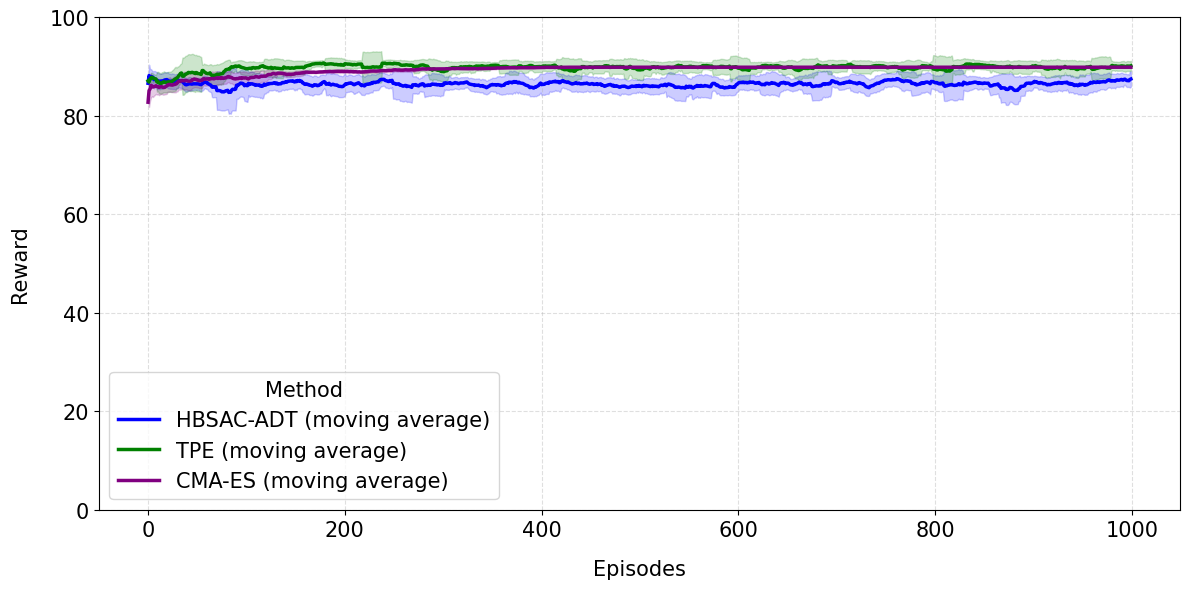

In [52]:
plot_learning_curves_from_df_mean_std_moving(
    results_df_iforest[['metodo', 'reward']],
    title="",
    model_colors=model_colors
)


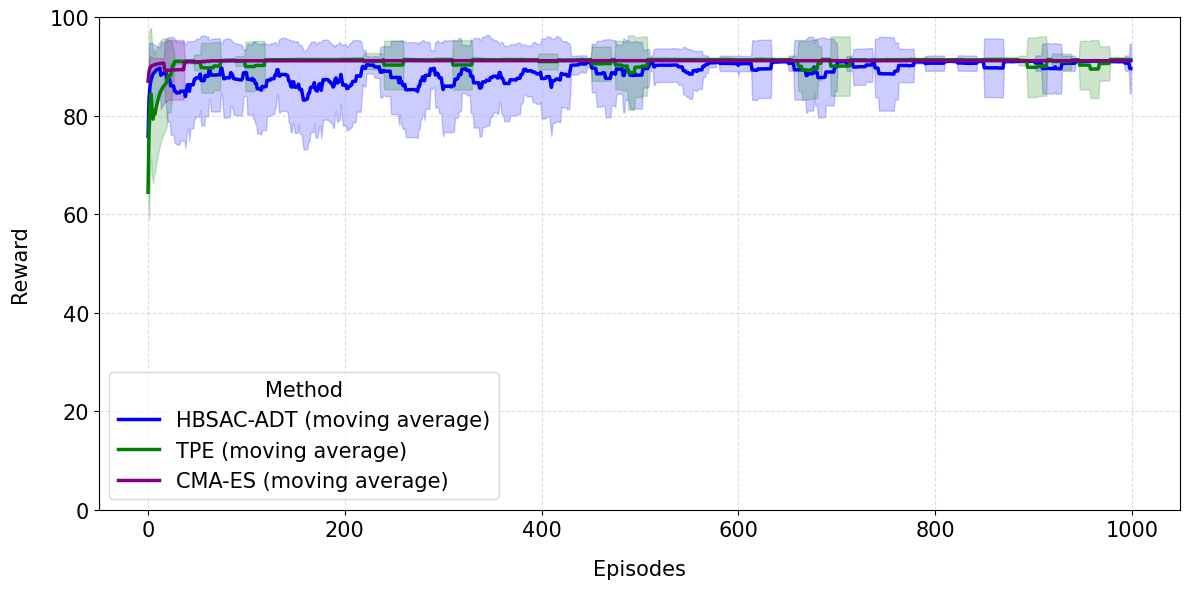

In [53]:
plot_learning_curves_from_df_mean_std_moving(
    results_df_lof[['metodo', 'reward']],
    title="",
    model_colors=model_colors
)


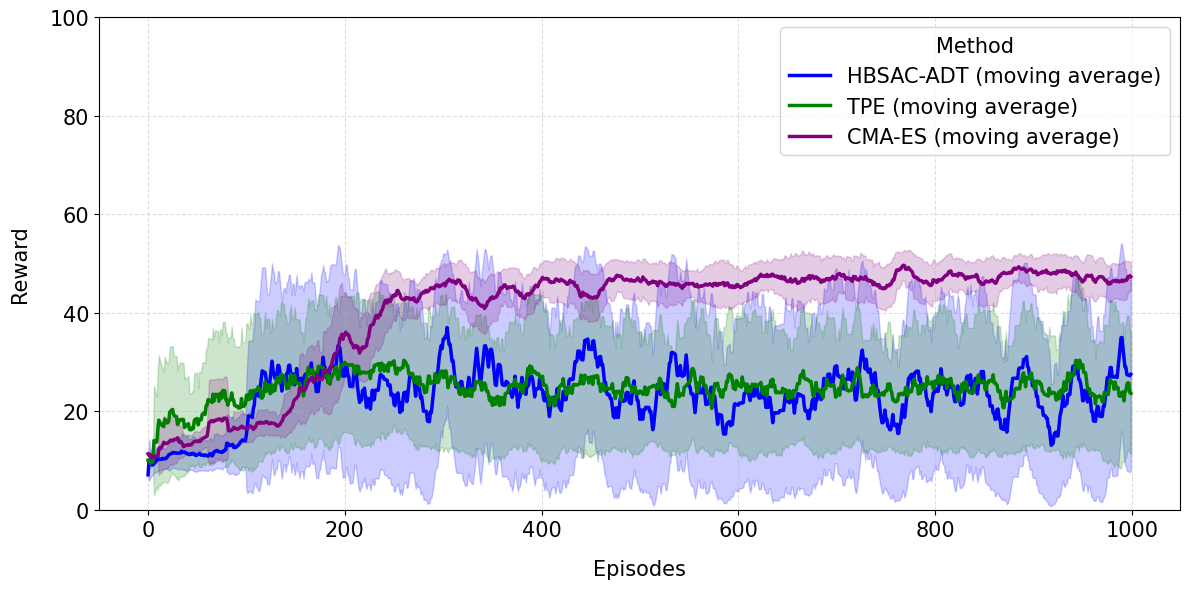

In [54]:
plot_learning_curves_from_df_mean_std_moving(
    results_df_loda[['metodo', 'reward']],
    title="",
    model_colors=model_colors
)


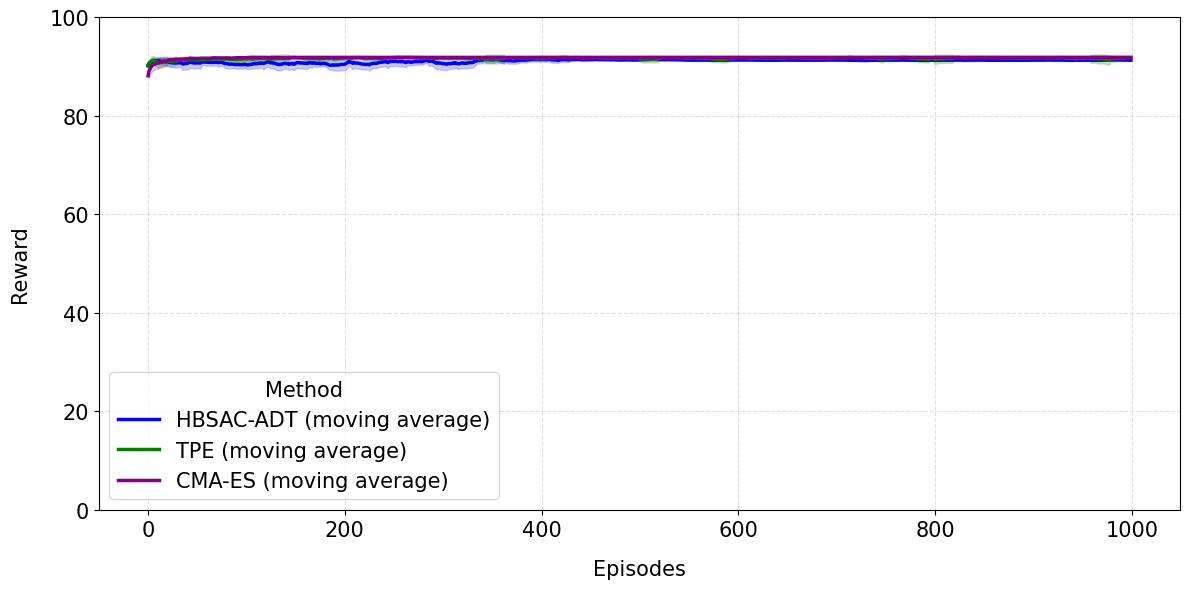

In [55]:
plot_learning_curves_from_df_mean_std_moving(
    results_df_pca[['metodo', 'reward']],
    title="",
    model_colors=model_colors
)


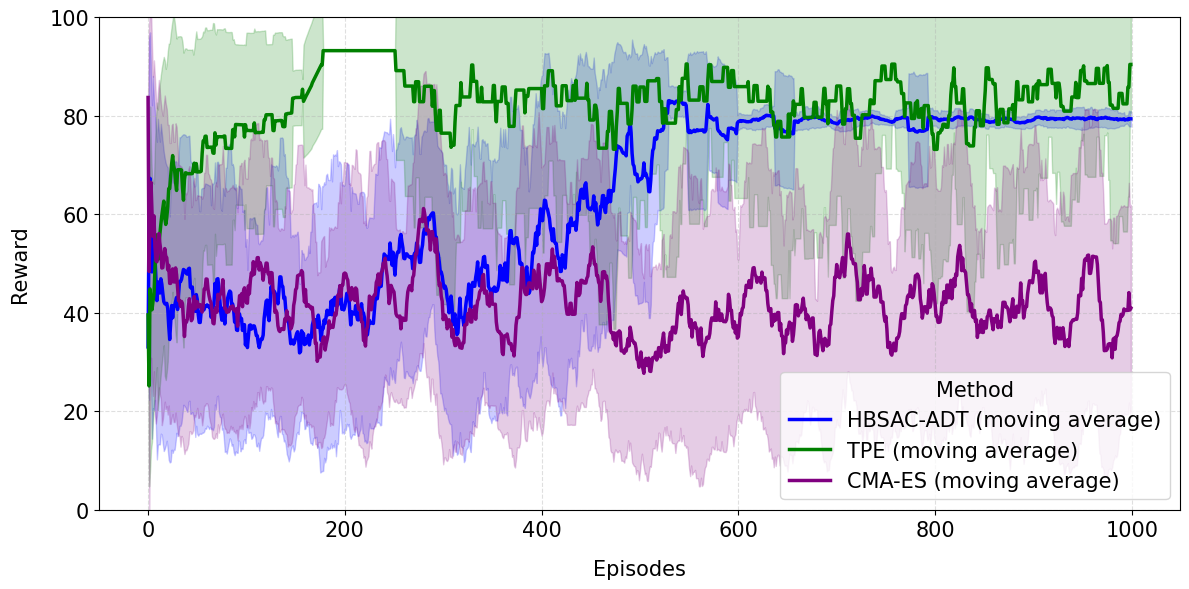

In [56]:
plot_learning_curves_from_df_mean_std_moving(
    results_df_ocsvm[['metodo', 'reward']],
    title="",
    model_colors=model_colors
)

In [57]:
results_df_iforest

,roc_auc_mean,roc_auc_std,metodo,trial,value,n_estimators,contamination,max_samples,max_features,reward
0,0.902232,0.036667,HBSAC-ADT,NaN,NaN,NaN,NaN,NaN,NaN,86.556544
1,0.918678,0.021817,HBSAC-ADT,NaN,NaN,NaN,NaN,NaN,NaN,89.686118
2,0.907594,0.039374,HBSAC-ADT,NaN,NaN,NaN,NaN,NaN,NaN,86.821991
3,0.911962,0.025216,HBSAC-ADT,NaN,NaN,NaN,NaN,NaN,NaN,88.674640
4,0.905985,0.030905,HBSAC-ADT,NaN,NaN,NaN,NaN,NaN,NaN,87.508082
...,...,...,...,...,...,...,...,...,...,...
995,0.933789,0.035715,CMA-ES,995.0,89.807446,203.0,0.000211,0.722125,0.586091,89.807446
996,0.933789,0.035715,CMA-ES,996.0,89.807446,203.0,0.000224,0.722919,0.585470,89.807446
997,0.933789,0.035715,CMA-ES,997.0,89.807446,203.0,0.000220,0.722748,0.585468,89.807446
998,0.933789,0.035715,CMA-ES,998.0,89.807446,203.0,0.000210,0.722441,0.585763,89.807446


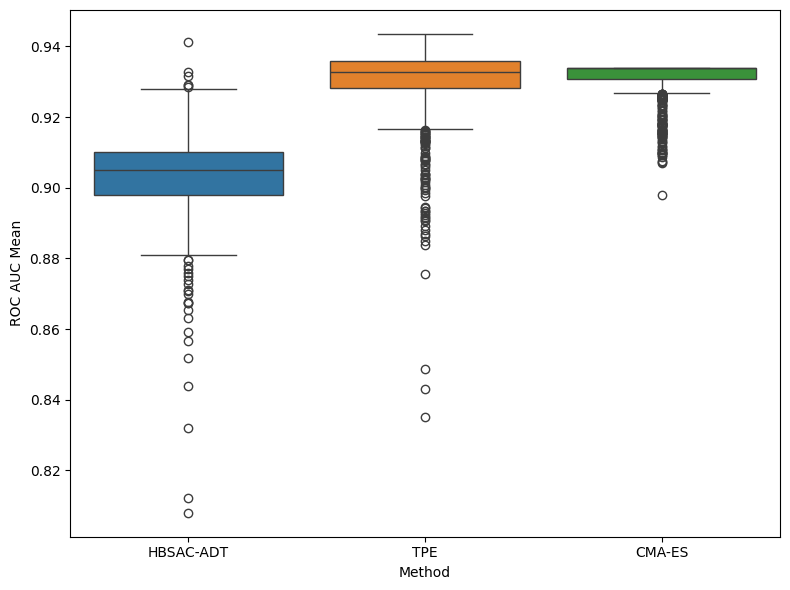

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df_iforest, x='metodo', y="roc_auc_mean", hue="metodo")
plt.xlabel("Method")
plt.ylabel("ROC AUC Mean")
plt.tight_layout()
plt.show()

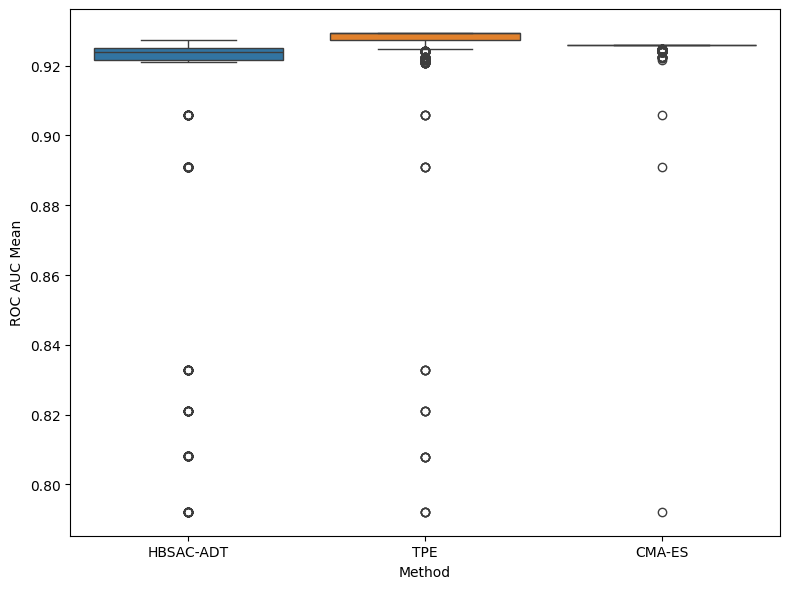

In [62]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df_lof, x='metodo', y="roc_auc_mean", hue="metodo")
plt.xlabel("Method")
plt.ylabel("ROC AUC Mean")
plt.tight_layout()
plt.show()

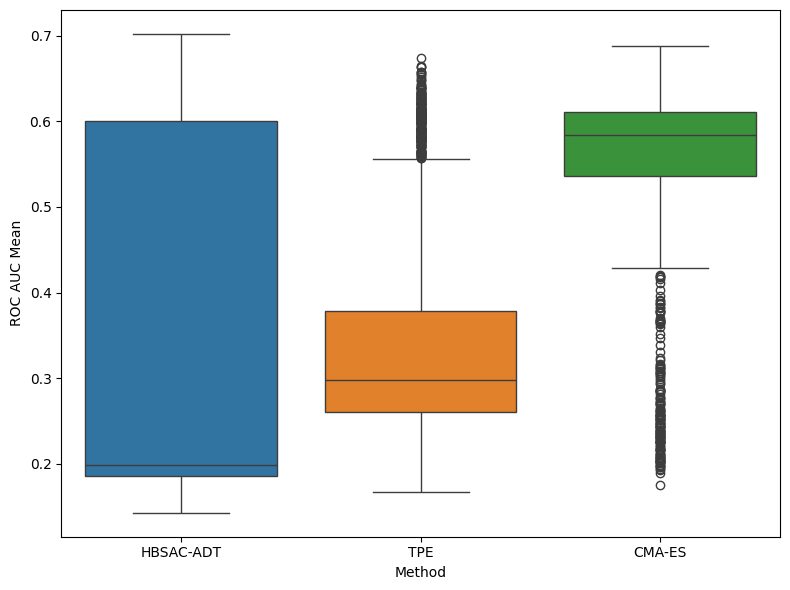

In [63]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df_loda, x='metodo', y="roc_auc_mean", hue="metodo")
plt.xlabel("Method")
plt.ylabel("ROC AUC Mean")
plt.tight_layout()
plt.show()

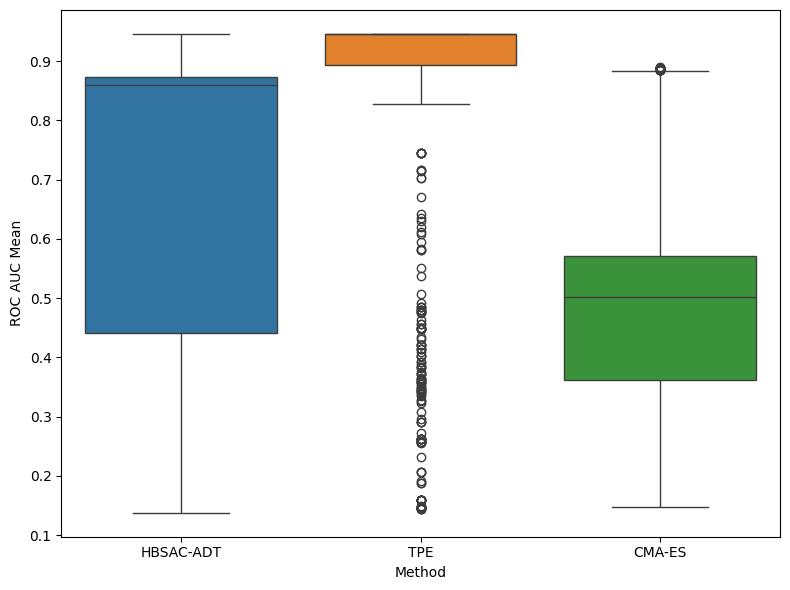

In [64]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df_ocsvm, x='metodo', y="roc_auc_mean", hue="metodo")
plt.xlabel("Method")
plt.ylabel("ROC AUC Mean")
plt.tight_layout()
plt.show()

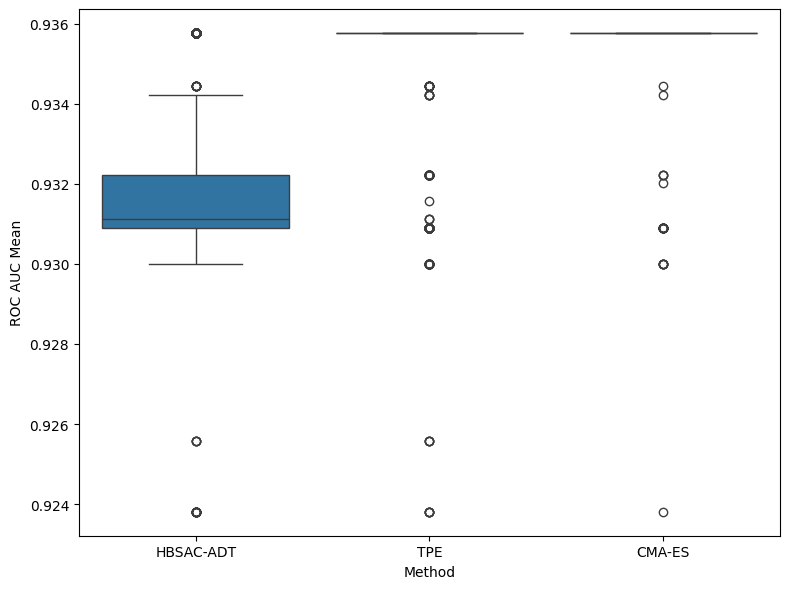

In [65]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df_pca, x='metodo', y="roc_auc_mean", hue="metodo")
plt.xlabel("Method")
plt.ylabel("ROC AUC Mean")
plt.tight_layout()
plt.show()

HBSAC-ADT


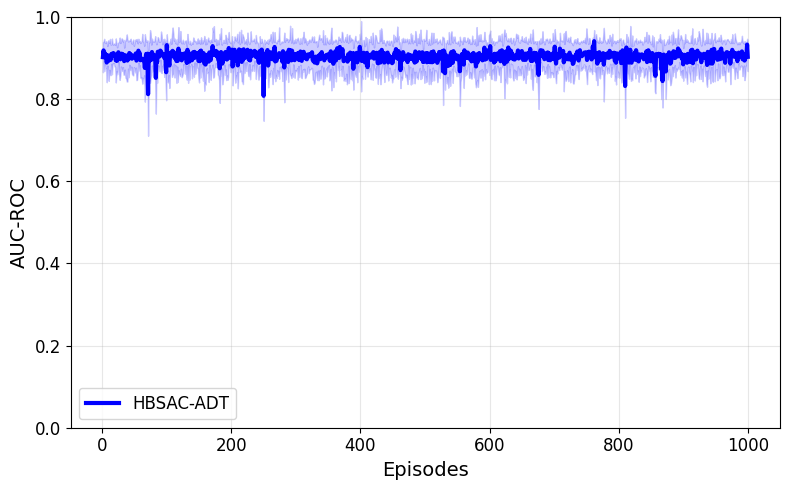

TPE


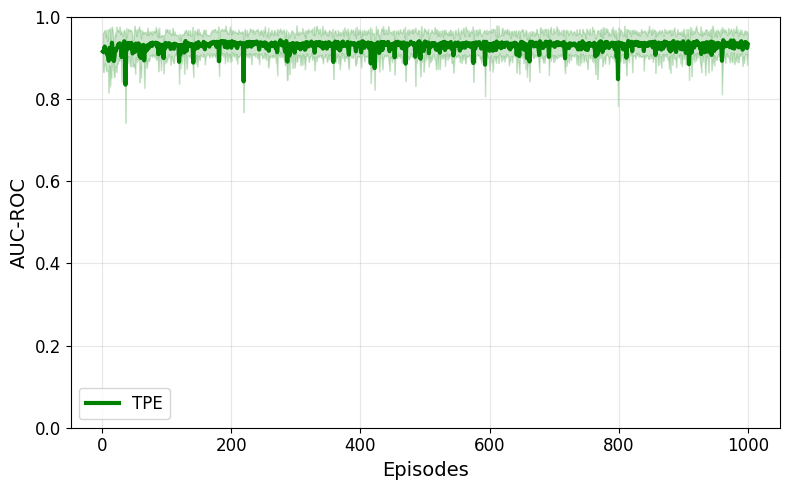

CMA-ES


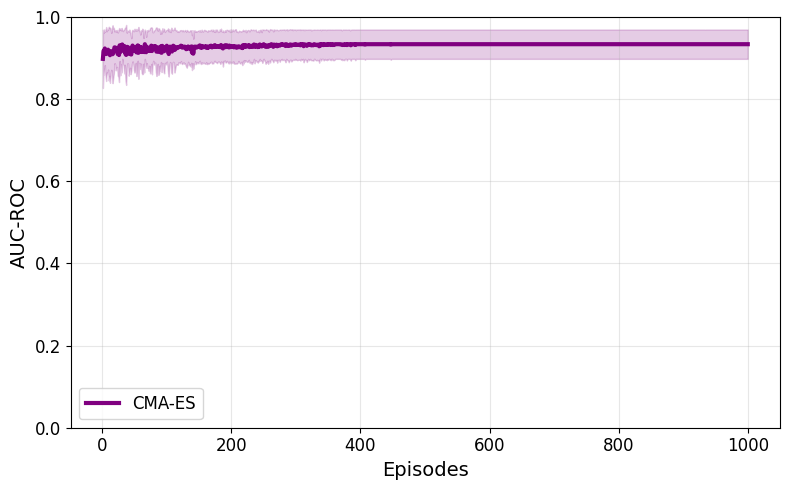

In [110]:
for metodo in metodos:
    print(metodo)
    plot_learning_curves_from_df(
        results_df_iforest[results_df_iforest['metodo'] == metodo],
        title=f"",
        model_colors={metodo: model_colors[metodo]}  # passa apenas a cor do método atual
    )
    plt.show()

HBSAC-ADT


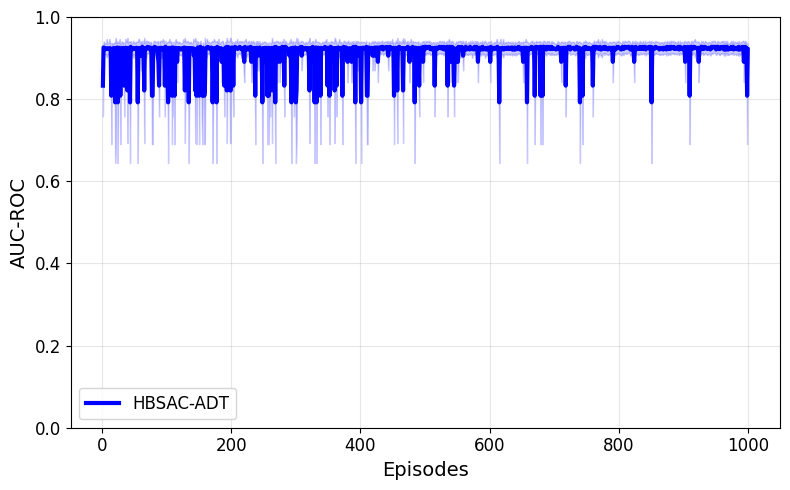

TPE


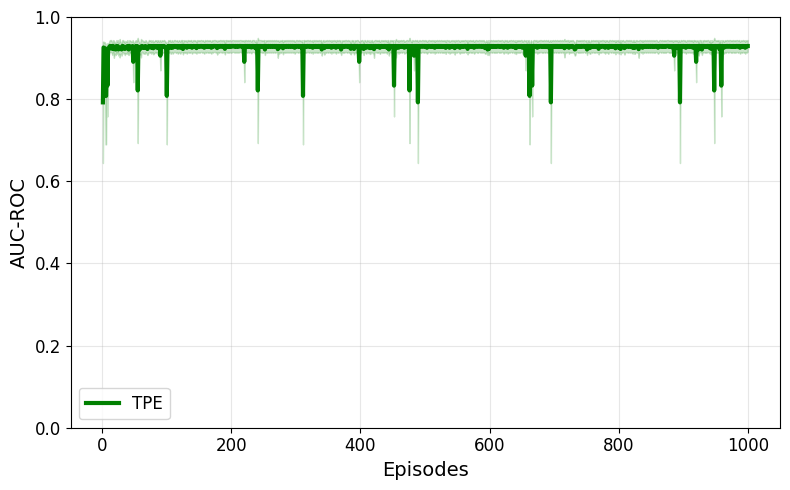

CMA-ES


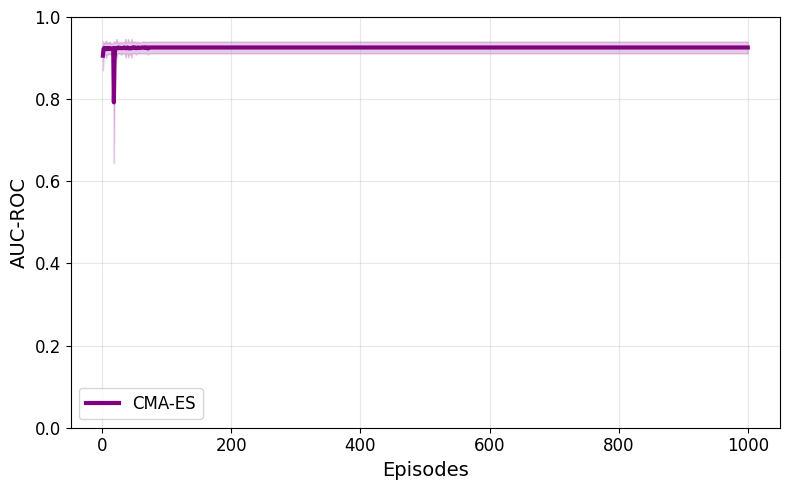

In [111]:
for metodo in metodos:
    print(metodo)
    plot_learning_curves_from_df(
        results_df_lof[results_df_lof['metodo'] == metodo],
        title=f"",
        model_colors={metodo: model_colors[metodo]}  # passa apenas a cor do método atual
    )
    plt.show()

HBSAC-ADT


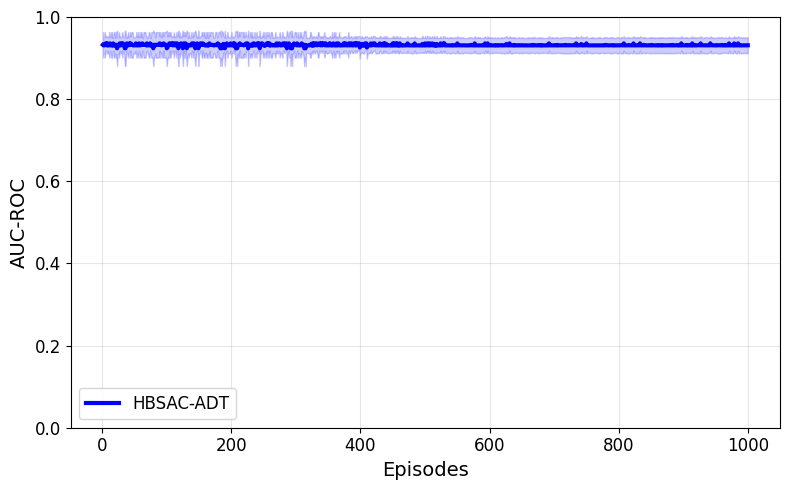

TPE


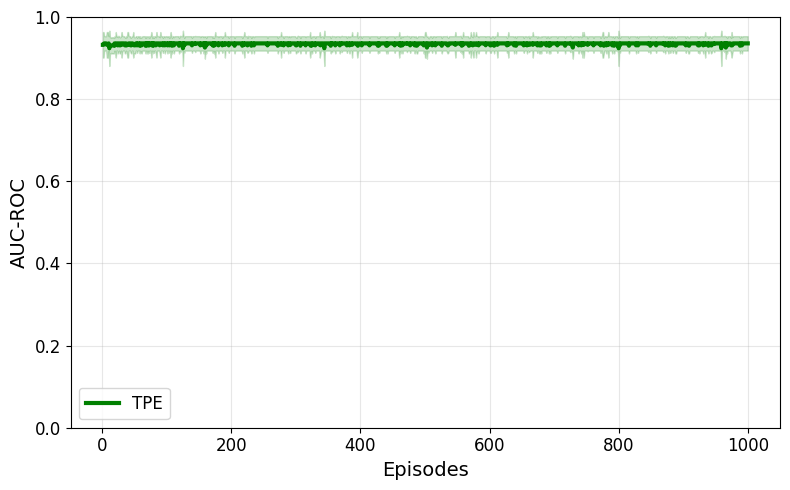

CMA-ES


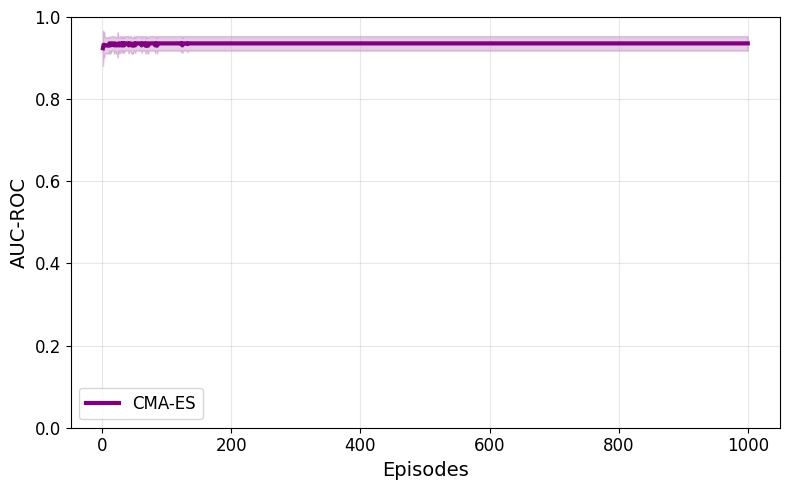

In [112]:
for metodo in metodos:
    print(metodo)
    plot_learning_curves_from_df(
        results_df_pca[results_df_pca['metodo'] == metodo],
        title=f"",
        model_colors={metodo: model_colors[metodo]}  # passa apenas a cor do método atual
    )
    plt.show()

HBSAC-ADT


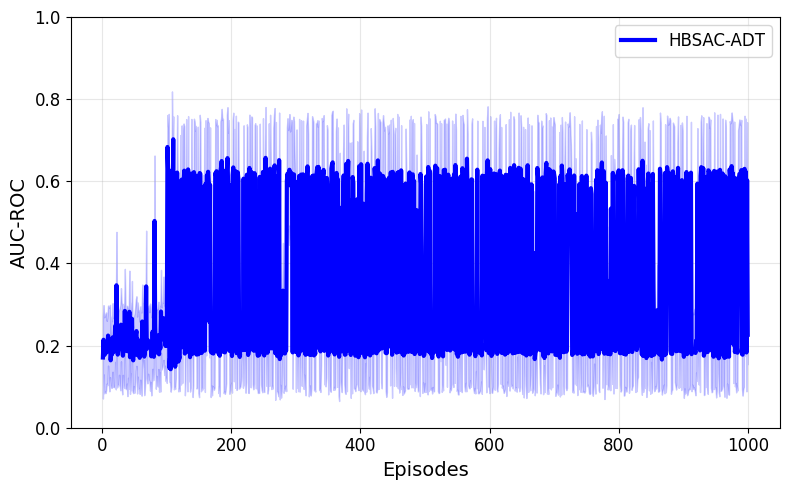

TPE


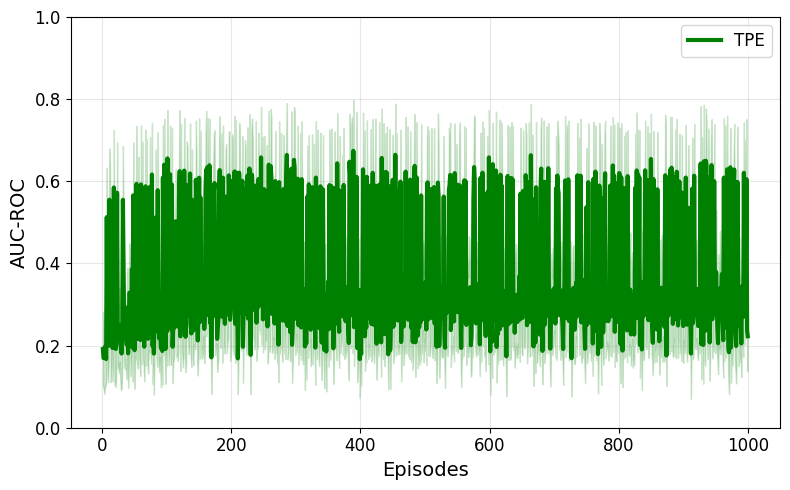

CMA-ES


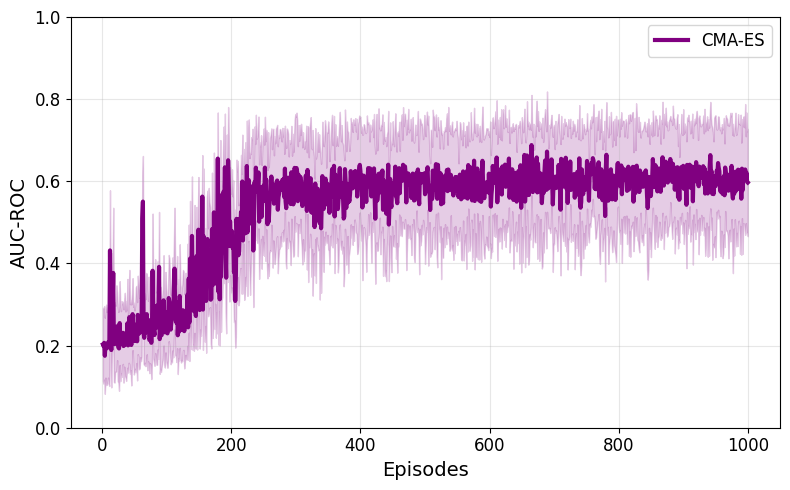

In [113]:
for metodo in metodos:
    print(metodo)
    plot_learning_curves_from_df(
        results_df_loda[results_df_loda['metodo'] == metodo],
        title=f"",
        model_colors={metodo: model_colors[metodo]}  # passa apenas a cor do método atual
    )
    plt.show()

HBSAC-ADT


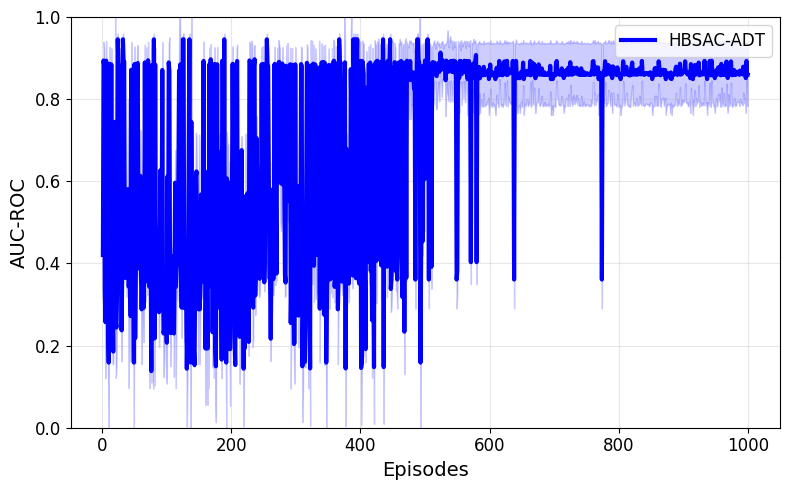

TPE


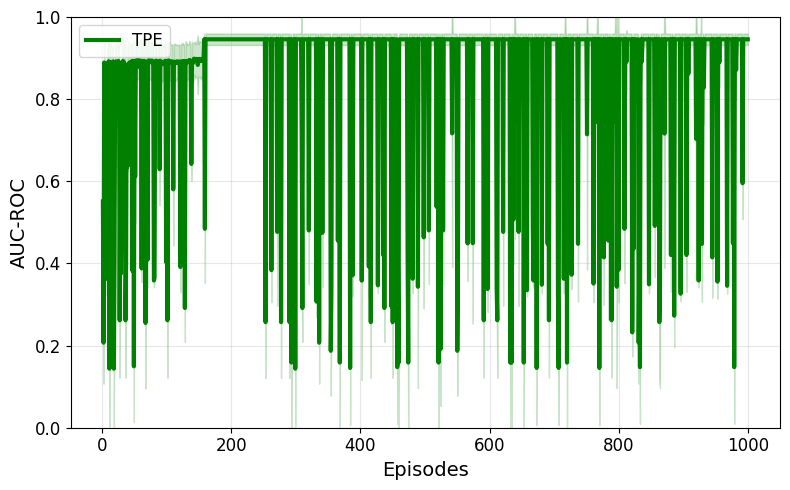

CMA-ES


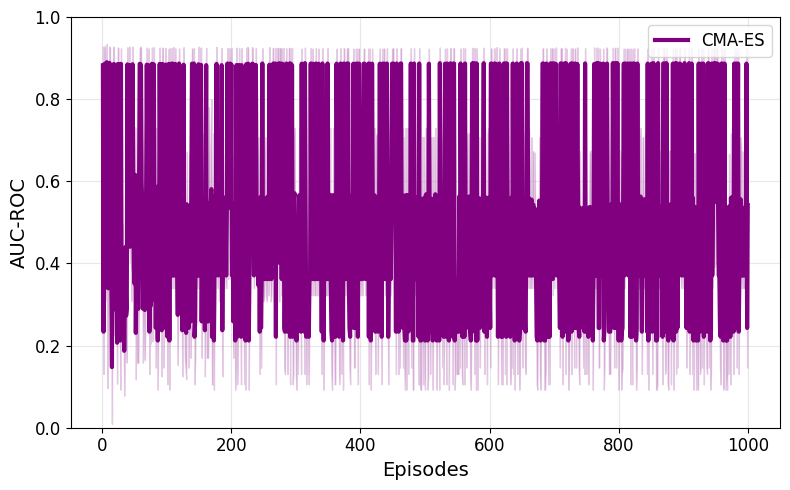

In [114]:
for metodo in metodos:
    print(metodo)
    plot_learning_curves_from_df(
        results_df_ocsvm[results_df_ocsvm['metodo'] == metodo],
        title=f"",
        model_colors={metodo: model_colors[metodo]}  # passa apenas a cor do método atual
    )
    plt.show()

### Q-values

In [115]:
results_q_values_iforest_mean = pd.read_csv(f'./metrics_skab/q_values_mean_history_iforest_dwt.csv')
results_q_values_iforest_std = pd.read_csv(f'./metrics_skab/q_values_std_history_iforest_dwt.csv')
results_q_values_lof_mean = pd.read_csv(f'./metrics_skab/q_values_mean_history_lof_dwt.csv')
results_q_values_lof_std = pd.read_csv(f'./metrics_skab/q_values_std_history_lof_dwt.csv')
results_q_values_loda_mean = pd.read_csv(f'./metrics_skab/q_values_mean_history_loda_dwt.csv')
results_q_values_loda_std = pd.read_csv(f'./metrics_skab/q_values_std_history_loda_dwt.csv')
results_q_values_pca_mean = pd.read_csv(f'./metrics_skab/q_values_mean_history_pca_dwt.csv')
results_q_values_pca_std = pd.read_csv(f'./metrics_skab/q_values_std_history_pca_dwt.csv')
results_q_values_ocsvm_mean = pd.read_csv(f'./metrics_skab/q_values_mean_history_ocsvm_dwt.csv')
results_q_values_ocsvm_std = pd.read_csv(f'./metrics_skab/q_values_std_history_ocsvm_dwt.csv')


In [116]:
results_q_values_iforest_std

,0
0,0.614160
1,0.677388
2,0.614391
3,0.644125
4,0.614180
...,...
995,0.075792
996,0.089500
997,0.134794
998,0.032072


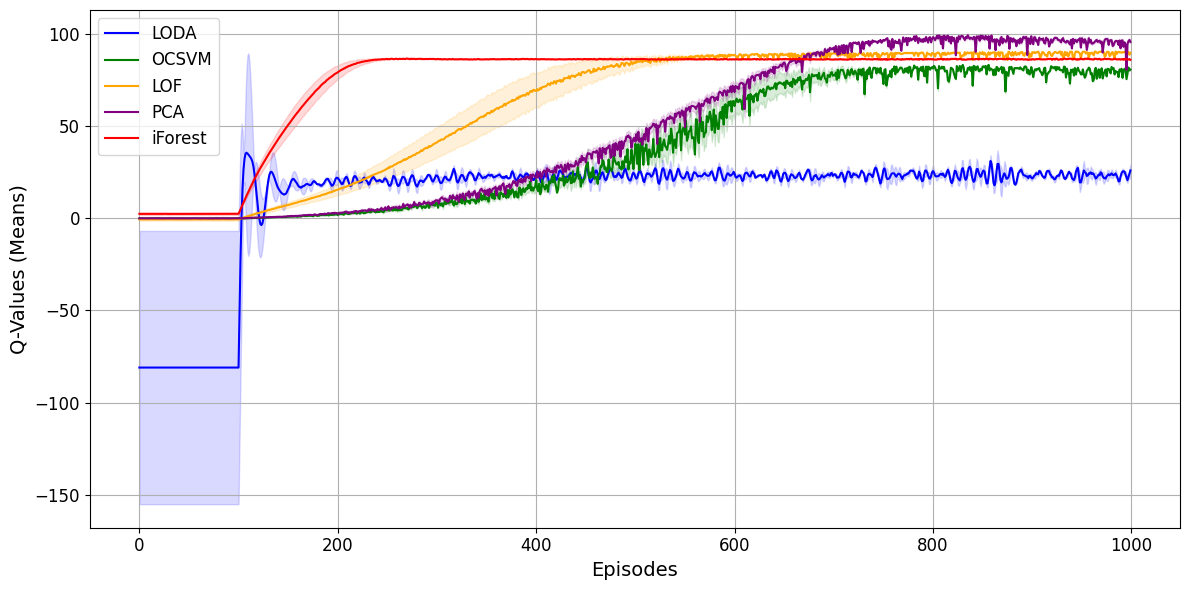

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Dicionário com os dados de cada modelo (substitua pelos seus DataFrames reais)
model_results = {
    "LODA": (results_q_values_loda_mean, results_q_values_loda_std),
    "OCSVM": (results_q_values_ocsvm_mean, results_q_values_ocsvm_std),
    "LOF": (results_q_values_lof_mean, results_q_values_lof_std),
    "PCA": (results_q_values_pca_mean, results_q_values_pca_std),
    "iForest": (results_q_values_iforest_mean, results_q_values_iforest_std)
}

# Paleta de cores para os modelos
colors = {
    "LODA": "blue",
    "OCSVM": "green",
    "LOF": "orange",
    "PCA": "purple",
    "iForest": "red"
}

plt.figure(figsize=(12, 6))

for model, (mean_df, std_df) in model_results.items():
    q_mean = mean_df.iloc[:, 0].to_numpy()
    q_std = std_df.iloc[:, 0].to_numpy()
    steps = np.arange(len(q_mean))

    plt.plot(steps, q_mean, label=f"{model}", color=colors[model])
    plt.fill_between(
        steps,
        q_mean - q_std,
        q_mean + q_std,
        alpha=0.15,
        color=colors[model]
    )

plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Q-Values (Means)", fontsize=14)
plt.title("")
# plt.legend()
plt.legend(loc="best", fontsize=12)
# Ajusta ticks do eixo X e Y
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [118]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Dicionário com os dados de cada modelo (substitua pelos seus DataFrames reais)
# model_results = {
#     "LODA": results_q_values_loda_mean,
#     "OCSVM": results_q_values_ocsvm_mean,
#     "LOF": results_q_values_lof_mean,
#     "PCA": results_q_values_pca_mean,
#     "iForest": results_q_values_iforest_mean
# }

# # Paleta de cores para os modelos
# colors = {
#     "LODA": "blue",
#     "OCSVM": "green",
#     "LOF": "orange",
#     "PCA": "purple",
#     "iForest": "red"
# }

# plt.figure(figsize=(12, 6))

# for model, mean_df in model_results.items():
#     q_mean = mean_df.iloc[:, 0].to_numpy()
#     steps = np.arange(len(q_mean))

#     plt.plot(steps, q_mean, label=f"{model}", color=colors[model])

# plt.xlabel("Episodes", fontsize=14)
# plt.ylabel("Q-Values (Means)", fontsize=14)
# plt.title("")
# plt.legend(loc="best", fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.grid(True)
# plt.tight_layout()
# plt.show()
